In [1]:
#import libraries....

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
import folium

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss,confusion_matrix,f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB,GaussianNB
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from mlxtend.classifier import StackingClassifier
from sklearn.preprocessing import Normalizer,MinMaxScaler,StandardScaler

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder



import datetime

import warnings
warnings.filterwarnings("ignore")

### Choosing metric
* From EDA part, It is sure that there is high class imbalance in the dataset. Also review_score 1,2,3 are very important, since misclassification of them would cause customer loss to the seller. So False positive should be the concern here. 
* Here precision and recall of each class is important. Precision of class 4,5 is more important and recall of 1,2,3 class is very important. So we can use f1 score,which is a combination of precision and recall, Since each is important to us we can consider Macro f1 score.. 
* Based on this observation and business problem, I choose Macro F1 score as metric. Also I want to check multi-class confusion matrix, so that we can observe the misclassification easily.

<b>Metric choosen,
    * Macro F1 score
    * Multi-class Confusion matrix

In [2]:
#load the data with all created features
data = pd.read_csv("data_with_advanced_features.csv")
data.drop("Unnamed: 0", inplace=True, axis=1)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113105 entries, 0 to 113104
Data columns (total 71 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       113105 non-null  object 
 1   payment_sequential             113105 non-null  int64  
 2   payment_type                   113105 non-null  object 
 3   payment_installments           113105 non-null  int64  
 4   payment_value                  113105 non-null  float64
 5   customer_id                    113105 non-null  object 
 6   order_status                   113105 non-null  object 
 7   order_purchase_timestamp       113105 non-null  object 
 8   order_approved_at              113105 non-null  object 
 9   order_delivered_carrier_date   113105 non-null  object 
 10  order_delivered_customer_date  113105 non-null  object 
 11  order_estimated_delivery_date  113105 non-null  object 
 12  review_score                  

In [4]:
#label encoding of seller_id
label = LabelEncoder()
seller = label.fit_transform(data.seller_id)
data["seller_id"] = seller


#label encoding of product id
label = LabelEncoder()
product = label.fit_transform(data.product_id)
data["product_id"] = product


In [5]:
#let us drop some of the columns which are not needed
data.drop(["order_id","customer_id","order_status","order_approved_at","order_delivered_carrier_date",
           "order_estimated_delivery_date","order_delivered_customer_date","customer_unique_id","customer_city",
          "seller_city","shipping_limit_date","seller_state","customer_state",
           "order_purchase_timestamp"],inplace=True,axis=1)

In [6]:
#shape of the data after dropping unnecessary columns
data.shape

(113105, 57)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113105 entries, 0 to 113104
Data columns (total 57 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   payment_sequential           113105 non-null  int64  
 1   payment_type                 113105 non-null  object 
 2   payment_installments         113105 non-null  int64  
 3   payment_value                113105 non-null  float64
 4   review_score                 113105 non-null  int64  
 5   zip_code_prefix_customer     113105 non-null  int64  
 6   lat_customer                 113105 non-null  float64
 7   lng_customer                 113105 non-null  float64
 8   product_id                   113105 non-null  int32  
 9   product_name_lenght          113105 non-null  float64
 10  product_description_lenght   113105 non-null  float64
 11  product_photos_qty           113105 non-null  float64
 12  product_weight_g             113105 non-null  float64
 13 

## 1.1 Stratified Splitting

In [8]:
#target variable is review_score
Y = data["review_score"]
X = data

In [9]:
#train test split with test size 25% and 75% of data as train
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.25,stratify=Y,random_state=10)

In [10]:
print("Dimensions of the splitted data :")
print("Train: ",x_train.shape,y_train.shape)
print("Test: ",x_test.shape,y_test.shape)

Dimensions of the splitted data :
Train:  (84828, 57) (84828,)
Test:  (28277, 57) (28277,)


In [11]:
#check the distribution of each class in train,test as well as original data
print("% Distribution of class labels in the total data :")
print(round(data["review_score"].value_counts(normalize=True)*100,2))
print("*"*50)

print("% Distribution of class labels in the train data :")
print(round(x_train["review_score"].value_counts(normalize=True)*100,2))
print("*"*50)

print("% Distribution of class labels in the test data :")
print(round(x_test["review_score"].value_counts(normalize=True)*100,2))
print("*"*50)


% Distribution of class labels in the total data :
5    57.15
4    19.21
1    11.71
3     8.46
2     3.47
Name: review_score, dtype: float64
**************************************************
% Distribution of class labels in the train data :
5    57.15
4    19.21
1    11.71
3     8.46
2     3.47
Name: review_score, dtype: float64
**************************************************
% Distribution of class labels in the test data :
5    57.15
4    19.21
1    11.71
3     8.46
2     3.47
Name: review_score, dtype: float64
**************************************************


* Distribution of each class label is same in train.test and original data.


<b><font color="red"> Data is highly imbalanced. % of class 2 is very less. So we might face problem of misclassification due to this imbalanced data. Before applying any advanced techniques, let us build simple models and check how model will perform with this data.</b>

<b> let us use simple CountVectorizer for categorical data.

## 1.2 Featurization:

### 1.2.1 Vectorization of categorical variables:

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

<b>1. payment_type

In [13]:
#payment_type 
vec = CountVectorizer()

vec.fit(x_train["payment_type"].values)

x_tr_pay_type = vec.transform(x_train.payment_type.values)
x_te_pay_type = vec.transform(x_test.payment_type.values)

print(x_tr_pay_type.shape)
print(x_te_pay_type.shape)


(84828, 4)
(28277, 4)


<b>2. order_item_id

In [16]:
x_train.order_item_id = x_train.order_item_id.astype(str)
x_test.order_item_id = x_test.order_item_id.astype(str)

In [17]:
#order_item_id 
vec = CountVectorizer(vocabulary=range(1,22))

vec.fit(x_train["order_item_id"])

x_tr_id = vec.transform(x_train.order_item_id)
x_te_id = vec.transform(x_test.order_item_id)

print(x_tr_id.shape)

print(x_te_id.shape)


(84828, 21)
(28277, 21)


<b>3. product_category_name

In [18]:
#product_category_name
vec = CountVectorizer()

vec.fit(x_train["product_category_name"].values)

x_tr_cat = vec.transform(x_train.product_category_name.values)
#x_cv_cat = vec.transform(x_cv.product_category_name.values).toarray()
x_te_cat = vec.transform(x_test.product_category_name.values)

print(x_tr_cat.shape)
#print(x_cv_cat.shape)
print(x_te_cat.shape)


(84828, 73)
(28277, 73)


### 1.2.2 Binary features

In [19]:
x_tr_same_state = x_train.same_state.values.reshape(-1,1)
x_te_same_state = x_test.same_state.values.reshape(-1,1)

x_tr_same_city = x_train.same_city.values.reshape(-1,1)
x_te_same_city = x_test.same_city.values.reshape(-1,1)

x_tr_late_shipping = x_train.late_shipping.values.reshape(-1,1)
x_te_late_shipping = x_test.late_shipping.values.reshape(-1,1)

x_tr_high_freight = x_train.high_freight.values.reshape(-1,1)
x_te_high_freight = x_test.high_freight.values.reshape(-1,1)

### 1.2.3 Numrical features

In [20]:

def scaling(train_data,test_data):
    """This function will standardize the numerical data"""
    norm = StandardScaler()

    norm.fit(train_data.values)

    x_tr_num = norm.transform(train_data.values)
    x_te_num = norm.transform(test_data.values)


    return x_tr_num,x_te_num

In [21]:
data.columns

Index(['payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'review_score', 'zip_code_prefix_customer',
       'lat_customer', 'lng_customer', 'product_id', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'order_item_id', 'seller_id', 'price', 'freight_value',
       'zip_code_prefix_seller', 'lat_seller', 'lng_seller',
       'product_category_name', 'estimated_time', 'actual_time',
       'diff_actual_estimated', 'diff_purchased_approved',
       'diff_purchased_courrier', 'distance', 'speed', 'same_state',
       'same_city', 'late_shipping', 'high_freight', 'seller_share',
       'bs_share', 'cust_share', 'bu_share', 'similarity',
       'seller_category_share', 'cat_seller_share', 'cust_category_share',
       'cat_cust_share', 'similarity_using_cat', 'size', 'delivery_day',
       'delivery_date', 'delivery_month', 'del

In [22]:
#data to be standardized
tr = x_train[["payment_sequential","payment_installments","payment_value","seller_id","product_id","seller_share","bu_share",
              "bs_share","cust_share",
          "lat_customer","lng_customer","lat_seller","lng_seller","product_name_lenght","product_description_lenght",
           "product_photos_qty","product_weight_g","size","price","delivery_day","delivery_date","delivery_month",
              "delivery_hour","purchased_day","purchased_date","purchased_month","purchased_hour","num_of_customers_for_seller",
              "num_of_sellers_for_cust","total_order_for_seller",
           "freight_value","estimated_time","actual_time","diff_actual_estimated","diff_purchased_approved",
           "diff_purchased_courrier","distance","speed","similarity","similarity_using_cat"]]

te = x_test[["payment_sequential","payment_installments","payment_value","seller_id","product_id","seller_share","bu_share",
              "bs_share","cust_share",
          "lat_customer","lng_customer","lat_seller","lng_seller","product_name_lenght","product_description_lenght",
           "product_photos_qty","product_weight_g","size","price","delivery_day","delivery_date","delivery_month",
              "delivery_hour","purchased_day","purchased_date","purchased_month","purchased_hour","num_of_customers_for_seller",
              "num_of_sellers_for_cust","total_order_for_seller",
           "freight_value","estimated_time","actual_time","diff_actual_estimated","diff_purchased_approved",
           "diff_purchased_courrier","distance","speed","similarity","similarity_using_cat"]]


In [23]:
#standardizing
x_tr_num,x_te_num = scaling(tr,te)

In [24]:
from scipy.sparse import hstack
#horizontal stacking of all the features
train = hstack((x_tr_pay_type,x_tr_id,x_tr_cat,x_tr_num,x_tr_same_state,
                   x_tr_same_city,x_tr_late_shipping,x_tr_high_freight)).toarray()

test = hstack((x_te_pay_type,x_te_id,x_te_cat,x_te_num,x_te_same_state,
                 x_te_same_city,x_te_late_shipping,x_te_high_freight)).toarray()

In [25]:
#shape of final train and test data
print("Shape of train data : ",train.shape)
print("Shape of test data : ",test.shape)

Shape of train data :  (84828, 142)
Shape of test data :  (28277, 142)


In [26]:
#reset the index of target variable
y_trains = y_train.reset_index()
y_train = y_trains["review_score"]

y_tests = y_test.reset_index()
y_test = y_tests["review_score"]

In [27]:
#saving all the train,test,y_train,y_test data as csv file
pd.DataFrame(train).to_csv("train.csv")
pd.DataFrame(test).to_csv("test.csv")
pd.DataFrame(y_train).to_csv("y_train.csv")
pd.DataFrame(y_test).to_csv("y_test.csv")

## 1.3 ML Models

<b> Plotting Confusion matrix

In [28]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    """This function will plot confusion matrix, precision matrix and recall matrix"""
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    
    labels = [1,2,3,4,5]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

<b>k-fold cross validation

In [47]:
def kfold(k,model,trains,y_trains):
    """This function will do stratified k-fold cross_validation"""
    kf = StratifiedKFold(n_splits=k)
    
    cv_f1_score = []
    for tr_ind,cv_ind in kf.split(trains,y_trains):
            
        x_tr,x_cv,y_tr,y_cv = trains[tr_ind],trains[cv_ind],y_trains[tr_ind],y_trains[cv_ind]
        
        model.fit(x_tr,y_tr)
        pred_cv = model.predict(x_cv)    
        cv_f1_score.append((f1_score(y_cv,pred_cv,average="macro",labels=[1,2,3,4,5])))
    
    return np.mean(cv_f1_score)               

### 1.3.1 Logistic regression
<b> One vs Rest with class_weight = balanced

Macro F1 score at C=1e-05 is 0.2667786760007065 
Macro F1 score at C=0.0001 is 0.2755378965564173 
Macro F1 score at C=0.001 is 0.27945397462502053 
Macro F1 score at C=0.01 is 0.28060695323811763 
Macro F1 score at C=0.1 is 0.2793416309176847 
Macro F1 score at C=1 is 0.2797501330074962 
Macro F1 score at C=10 is 0.27940265832423244 
**************************************************


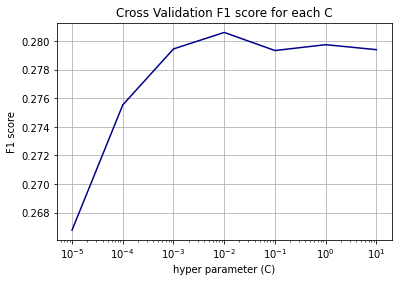

**************************************************
Train F1 score at 0.01 is :0.2859309445799382
**************************************************
test F1 score at 0.01 is :0.28356443530884495
-------------------- Confusion matrix --------------------


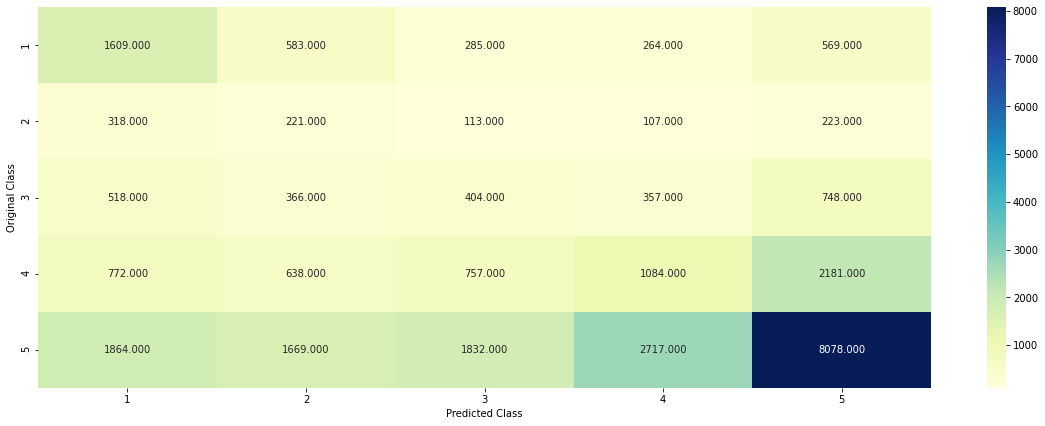

-------------------- Precision matrix (Columm Sum=1) --------------------


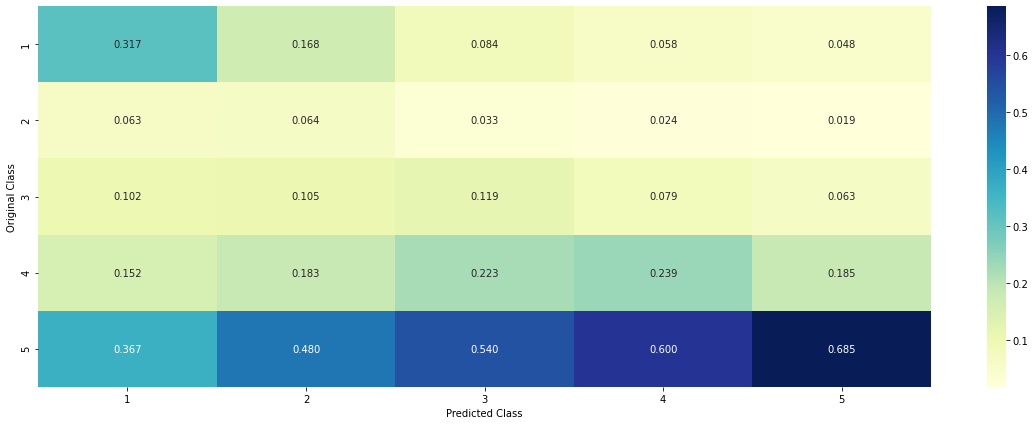

-------------------- Recall matrix (Row sum=1) --------------------


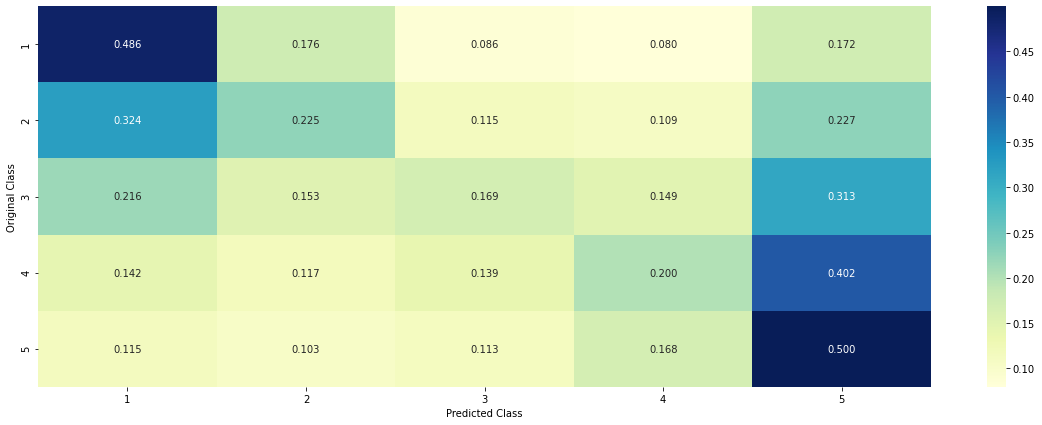

In [30]:
C=[0.00001,0.0001,0.001,0.01,0.1,1,10]

f1_scores = []
for i in C:
    model = None
    model = LogisticRegression(C=i,class_weight="balanced")
    k_fold_score = kfold(5,model)
    f1_scores.append(k_fold_score)
    print("Macro F1 score at C={} is {} ".format(i,k_fold_score))

    
    
print("*"*50)    
plt.plot(C,f1_scores,color="darkblue")
plt.xscale("log")
plt.grid()
plt.title("Cross Validation F1 score for each C")
plt.xlabel("hyper parameter (C)")
plt.ylabel("F1 score")
plt.show()

best_param = C[np.argmax(f1_scores)]

model = None
model = LogisticRegression(C=i,class_weight="balanced")
model.fit(train,y_train)


print("*"*50)
print("Train F1 score at {} is :{}".format(best_param, f1_score(y_train,model.predict(train),labels=model.classes_,average="macro")))
print("*"*50)
print("test F1 score at {} is :{}".format(best_param, f1_score(y_test,model.predict(test),labels=model.classes_,average="macro")))


#plotting confusion matrix
predicted = model.predict(test)
plot_confusion_matrix(y_test,predicted)

Macro F1 score at C=0.009 is 0.2804181734297707 
Macro F1 score at C=0.01 is 0.28060695323811763 
Macro F1 score at C=0.02 is 0.2800099384943631 
Macro F1 score at C=0.03 is 0.28000319502996324 
Macro F1 score at C=0.05 is 0.2796378261604237 
Macro F1 score at C=0.09 is 0.2791679732793583 
**************************************************


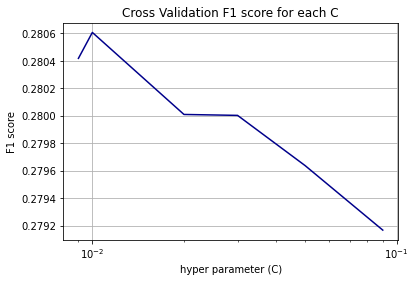

**************************************************
Train F1 score at 0.01 is :0.2861436760880077
**************************************************
test F1 score at 0.01 is :0.2830931443905419
-------------------- Confusion matrix --------------------


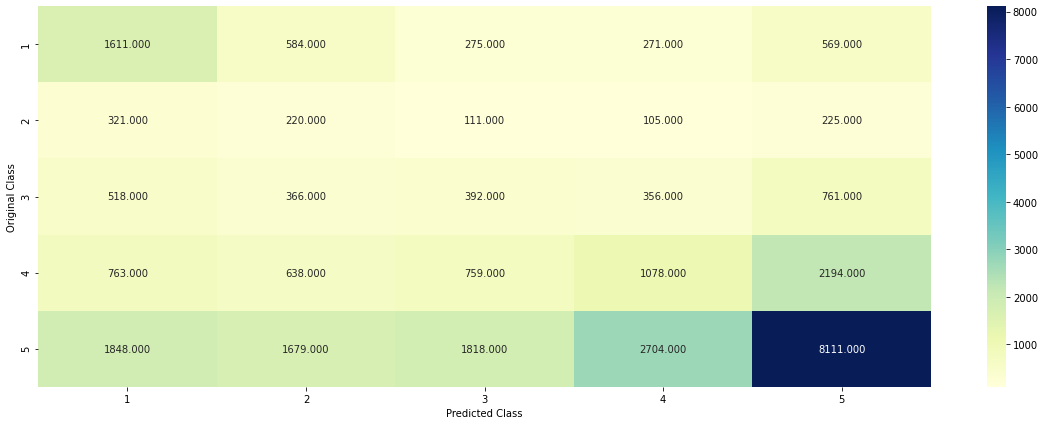

-------------------- Precision matrix (Columm Sum=1) --------------------


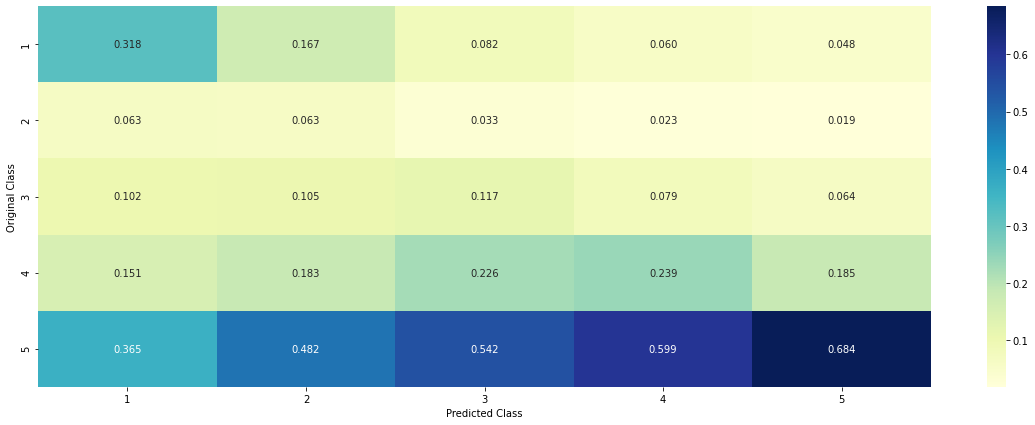

-------------------- Recall matrix (Row sum=1) --------------------


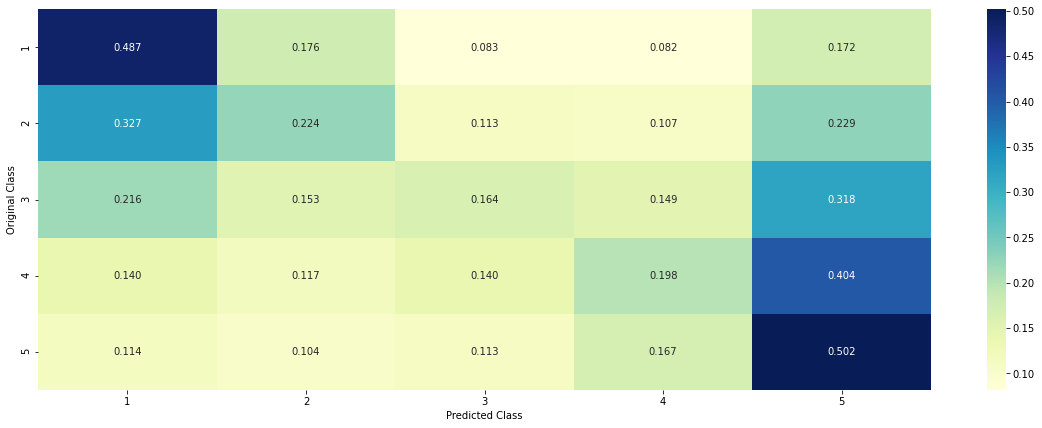

In [33]:
C=[0.009,0.01,0.02,0.03,0.05,0.09]

f1_scores = []
for i in C:
    model = None
    model = LogisticRegression(C=i,class_weight="balanced")
    k_fold_score = kfold(5,model)
    f1_scores.append(k_fold_score)
    print("Macro F1 score at C={} is {} ".format(i,k_fold_score))

    
    
print("*"*50)    
plt.plot(C,f1_scores,color="darkblue")
#plt.xscale("log")
plt.grid()
plt.title("Cross Validation F1 score for each C")
plt.xlabel("hyper parameter (C)")
plt.ylabel("F1 score")
plt.show()

best_param = C[np.argmax(f1_scores)]

model = None
model = LogisticRegression(C=i,class_weight="balanced")
model.fit(train,y_train)


print("*"*50)
print("Train F1 score at {} is :{}".format(best_param, f1_score(y_train,model.predict(train),labels=model.classes_,average="macro")))
print("*"*50)
print("test F1 score at {} is :{}".format(best_param, f1_score(y_test,model.predict(test),labels=model.classes_,average="macro")))


#plotting confusion matrix
predicted = model.predict(test)
plot_confusion_matrix(y_test,predicted)

* First I tried simple logistic regression to check whether the data is linearly separable or not. 
* But we don't get good results from this model. 
* The performance of this model is not at all good. There are high misclassification, and macro f1 score is very less.
* Out of all review_score 5 only 50% of points are correctly predicted as class 5. 
* Out of all class 5 classified points only 68% are actually class 5.
* This misclassification problem is there in all class labels.
* Precision and recall of class label 2,3 are very low.

* So, the data seems to be not linearly separable.

### 1.3.2 SVM

Macro F1 score at alpha=1e-05 is 0.22667955962631292 
Macro F1 score at alpha=0.0001 is 0.2224246339809955 
Macro F1 score at alpha=0.001 is 0.21587831678954625 
Macro F1 score at alpha=0.01 is 0.20566121048715855 
Macro F1 score at alpha=0.1 is 0.18686707882280684 
Macro F1 score at alpha=1 is 0.1474467601768059 
Macro F1 score at alpha=10 is 0.14554671810346959 
**************************************************


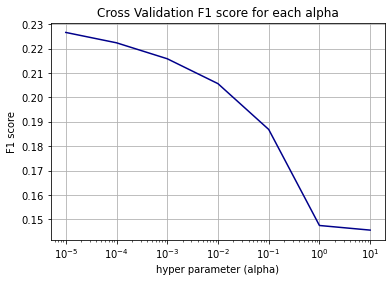

**************************************************
Train F1 score at 1e-05 is :0.1455032757226727
**************************************************
test F1 score at 1e-05 is :0.14546436528118462
-------------------- Confusion matrix --------------------


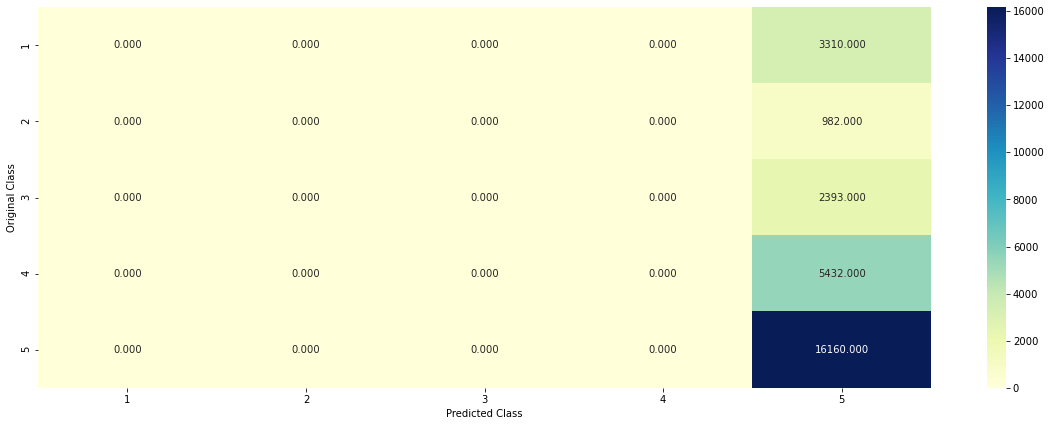

-------------------- Precision matrix (Columm Sum=1) --------------------


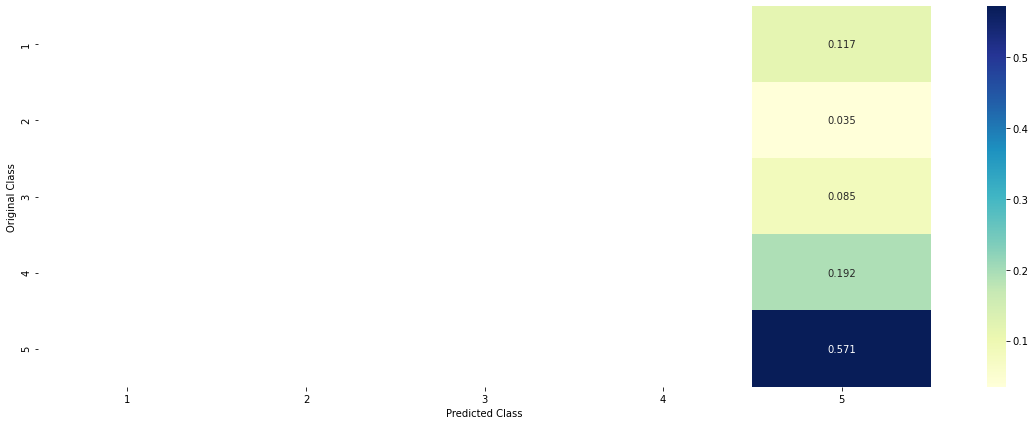

-------------------- Recall matrix (Row sum=1) --------------------


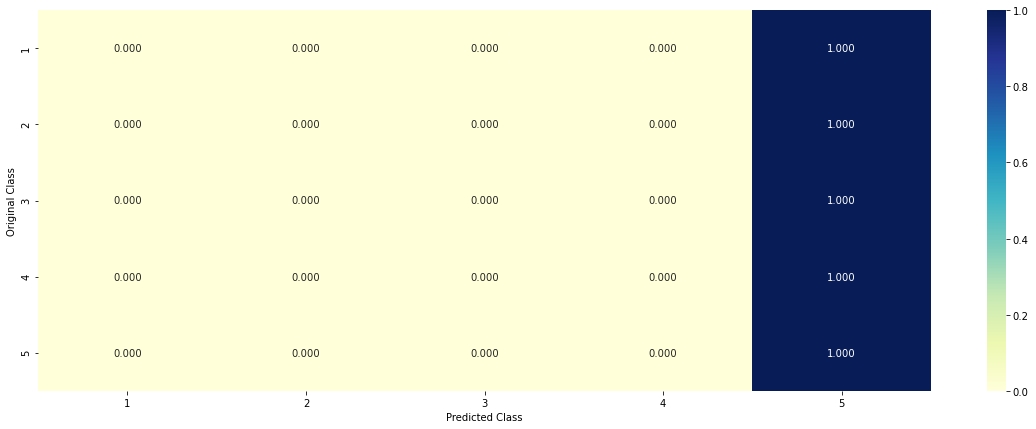

In [32]:
alpha=[0.00001,0.0001,0.001,0.01,0.1,1,10]

f1_scores = []
for i in alpha:
    model = None
    model = SGDClassifier(alpha=i,loss="hinge")
    k_fold_score = kfold(5,model)
    f1_scores.append(k_fold_score)
    print("Macro F1 score at alpha={} is {} ".format(i,k_fold_score))

    
    
print("*"*50)    
plt.plot(alpha,f1_scores,color="darkblue")
plt.xscale("log")
plt.grid()
plt.title("Cross Validation F1 score for each alpha")
plt.xlabel("hyper parameter (alpha)")
plt.ylabel("F1 score")
plt.show()

best_param = alpha[np.argmax(f1_scores)]

model = None
model = SGDClassifier(alpha=i,loss="hinge")
model.fit(train,y_train)


print("*"*50)
print("Train F1 score at {} is :{}".format(best_param, f1_score(y_train,model.predict(train),labels=model.classes_,average="macro")))
print("*"*50)
print("test F1 score at {} is :{}".format(best_param, f1_score(y_test,model.predict(test),labels=model.classes_,average="macro")))


#plotting confusion matrix
predicted = model.predict(test)
plot_confusion_matrix(y_test,predicted)

* This is worst model.
* It classifies every point as class 5. 
* SVM is not able to distinguish among classes.

### 1.3.3 KNN

In [31]:
from sklearn.neighbors import KNeighborsClassifier


Macro F1 score at n=3 is 0.33731364999563346 
Macro F1 score at n=5 is 0.3345040369305531 
Macro F1 score at n=7 is 0.3109171442984063 
Macro F1 score at n=9 is 0.29489979526225596 
Macro F1 score at n=11 is 0.28326470501836726 
Macro F1 score at n=13 is 0.2706057850190862 
**************************************************


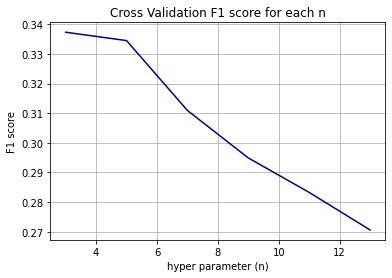

**************************************************
Train F1 score at 3 is :0.6482092305976689
**************************************************
test F1 score at 3 is :0.3507236050975718
-------------------- Confusion matrix --------------------


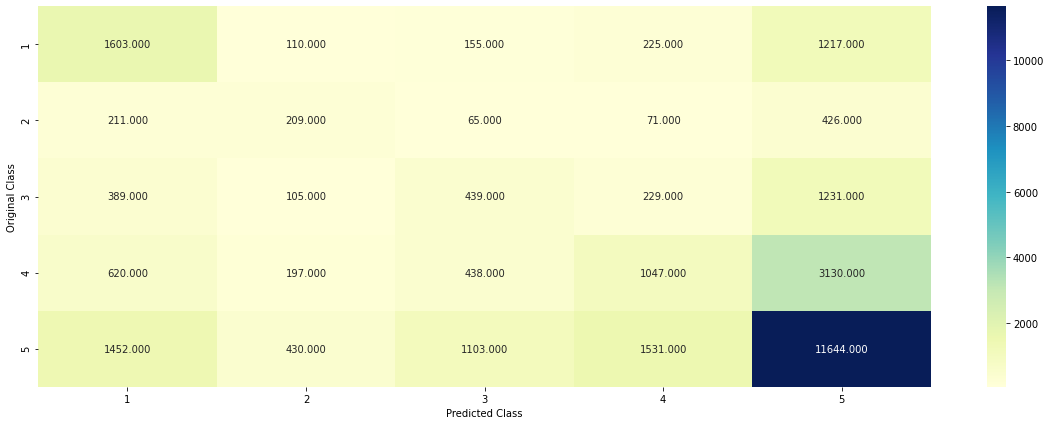

-------------------- Precision matrix (Columm Sum=1) --------------------


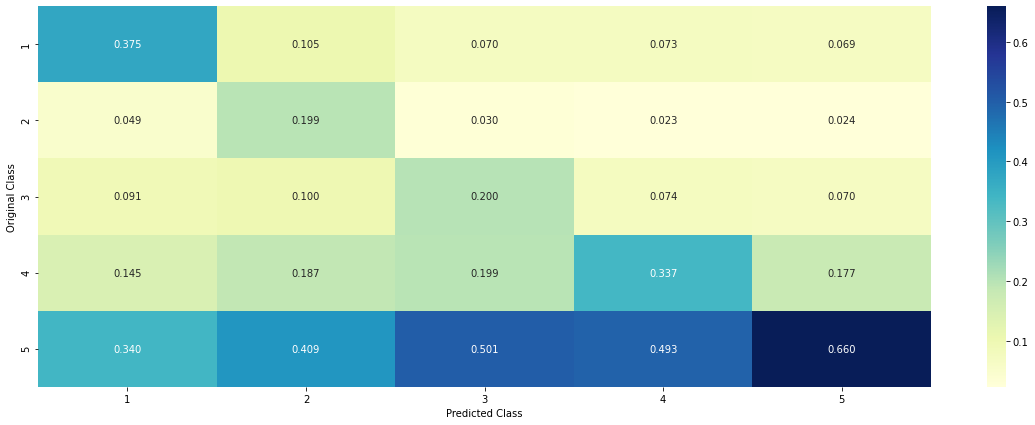

-------------------- Recall matrix (Row sum=1) --------------------


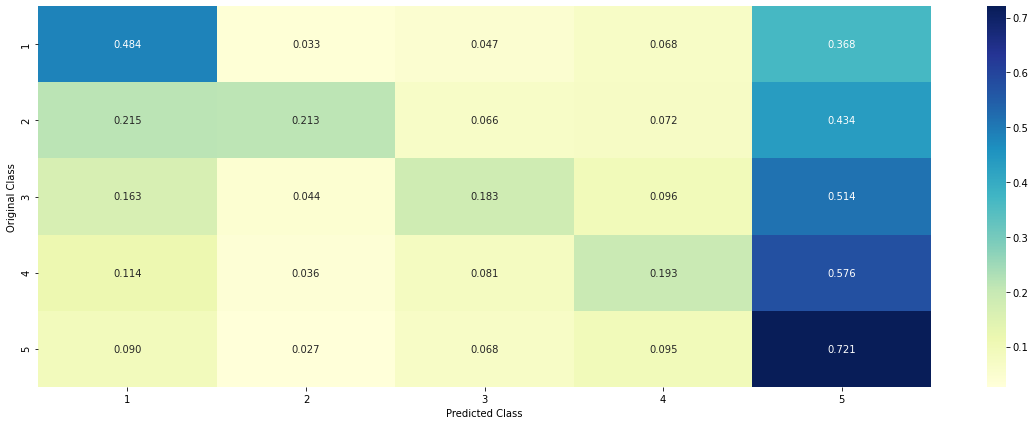

In [32]:
n=[3,5,7,9,11,13]

f1_scores = []
for i in n:
    model = None
    model = KNeighborsClassifier(n_neighbors=i)
    k_fold_score = kfold(5,model)
    f1_scores.append(k_fold_score)
    print("Macro F1 score at n={} is {} ".format(i,k_fold_score))

    
    
print("*"*50)    
plt.plot(n,f1_scores,color="darkblue")

plt.grid()
plt.title("Cross Validation F1 score for each n")
plt.xlabel("hyper parameter (n)")
plt.ylabel("F1 score")
plt.show()

best_param = n[np.argmax(f1_scores)]

model = None
model = KNeighborsClassifier(n_neighbors=best_param)
model.fit(train,y_train)


print("*"*50)
print("Train F1 score at {} is :{}".format(best_param, f1_score(y_train,model.predict(train),labels=model.classes_,average="macro")))
print("*"*50)
print("test F1 score at {} is :{}".format(best_param, f1_score(y_test,model.predict(test),labels=model.classes_,average="macro")))


#plotting confusion matrix
predicted = model.predict(test)
plot_confusion_matrix(y_test,predicted)

* This model seems to be little bit overfitting.
* Precision as well as recall of class 2,3,4 are better than logistic regression results.
* But we need very high recall for class 1,2,3. Also high precision for class 4 and 5. We need to improve this.

### 1.3.4. Decision Tree

In [34]:
from sklearn.tree import DecisionTreeClassifier

Macro F1 score at n=2 is 0.2239007983602522 
Macro F1 score at n=5 is 0.2711927629949459 
Macro F1 score at n=6 is 0.2758960078341464 
Macro F1 score at n=8 is 0.2844841878704538 
Macro F1 score at n=10 is 0.2877129470699218 
Macro F1 score at n=12 is 0.29600247646173894 
Macro F1 score at n=15 is 0.3079512516658536 
**************************************************


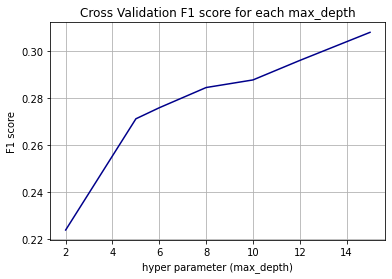

**************************************************
Train F1 score at 15 is :0.44340009830874527
**************************************************
test F1 score at 15 is :0.3206623596966399
-------------------- Confusion matrix --------------------


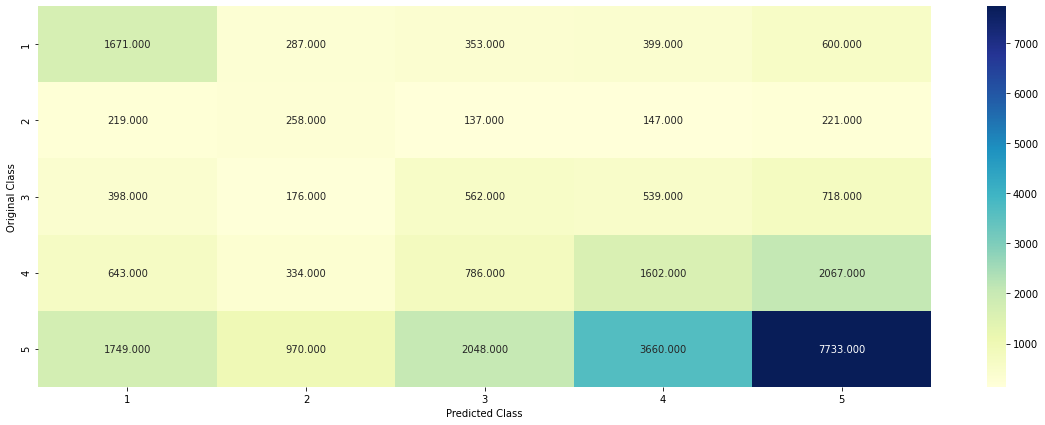

-------------------- Precision matrix (Columm Sum=1) --------------------


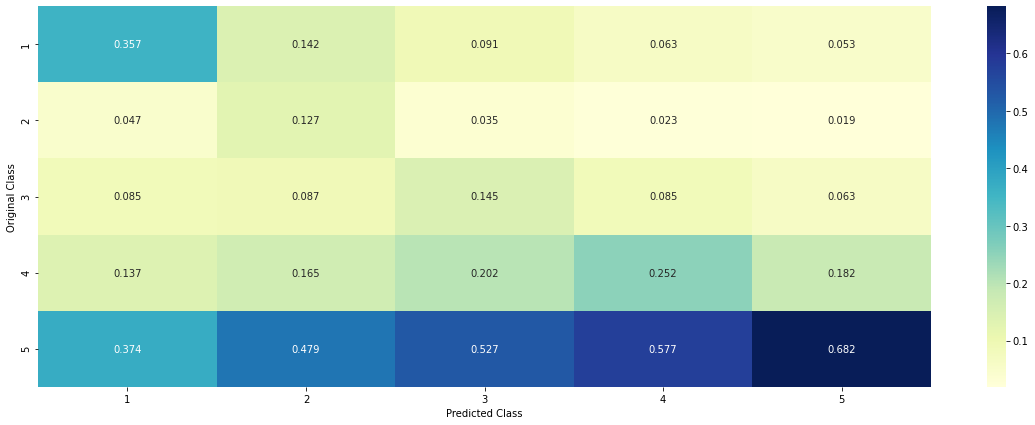

-------------------- Recall matrix (Row sum=1) --------------------


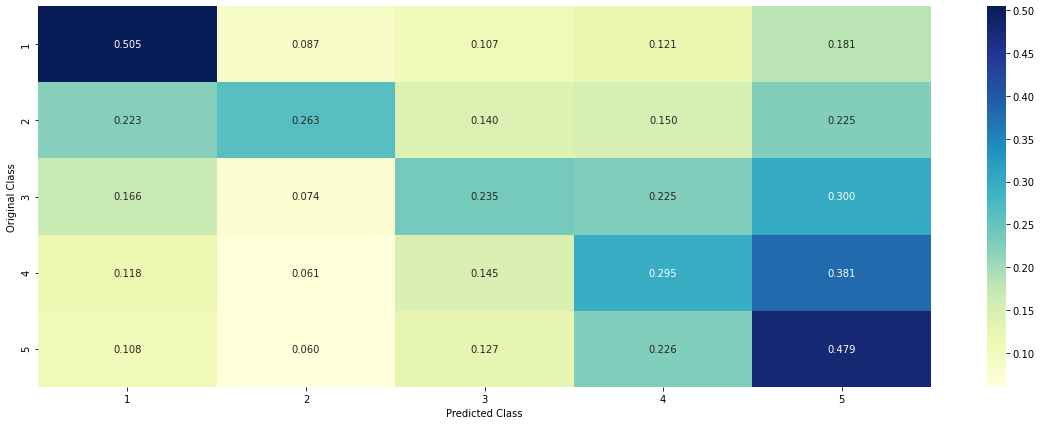

In [35]:
max_depth=[2,5,6,8,10,12,15]

f1_scores = []
for i in max_depth:
    model = None
    model = DecisionTreeClassifier(max_depth=i,class_weight="balanced")
    k_fold_score = kfold(5,model)
    f1_scores.append(k_fold_score)
    print("Macro F1 score at n={} is {} ".format(i,k_fold_score))

    
    
print("*"*50)    
plt.plot(max_depth,f1_scores,color="darkblue")

plt.grid()
plt.title("Cross Validation F1 score for each max_depth")
plt.xlabel("hyper parameter (max_depth)")
plt.ylabel("F1 score")
plt.show()

best_param = max_depth[np.argmax(f1_scores)]

model = None
model = DecisionTreeClassifier(max_depth=best_param,class_weight="balanced")
model.fit(train,y_train)


print("*"*50)
print("Train F1 score at {} is :{}".format(best_param, f1_score(y_train,model.predict(train),labels=model.classes_,average="macro")))
print("*"*50)
print("test F1 score at {} is :{}".format(best_param, f1_score(y_test,model.predict(test),labels=model.classes_,average="macro")))


#plotting confusion matrix
predicted = model.predict(test)
plot_confusion_matrix(y_test,predicted)

* This model also seems little overfitted. But recall of class 2,3,4 has imrpoved compared to previous models.
* Let us build Random Forest and will see the performance

### 1.3.5. Random Forest classifier

In [39]:
from sklearn.ensemble import RandomForestClassifier

Macro F1 score at n=10 is 0.4077635250527141 
Macro F1 score at n=20 is 0.4262404492228374 
Macro F1 score at n=50 is 0.4225952040360772 
Macro F1 score at n=100 is 0.4288806797359914 
Macro F1 score at n=150 is 0.4294269621112063 
Macro F1 score at n=200 is 0.43443851367103414 
Macro F1 score at n=300 is 0.4307376260580201 
Macro F1 score at n=500 is 0.4330451401663538 
**************************************************


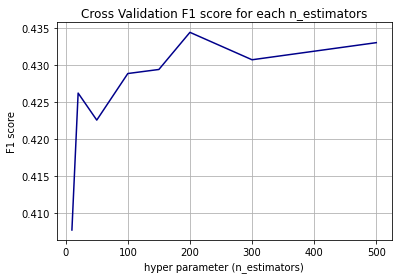

**************************************************
Train F1 score at 200 is :0.996856561806245
**************************************************
test F1 score at 200 is :0.47516460218276235
-------------------- Confusion matrix --------------------


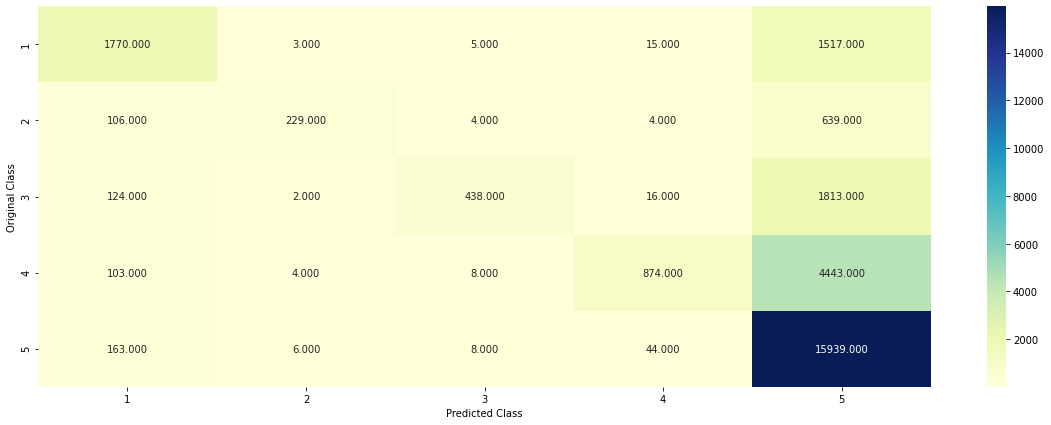

-------------------- Precision matrix (Columm Sum=1) --------------------


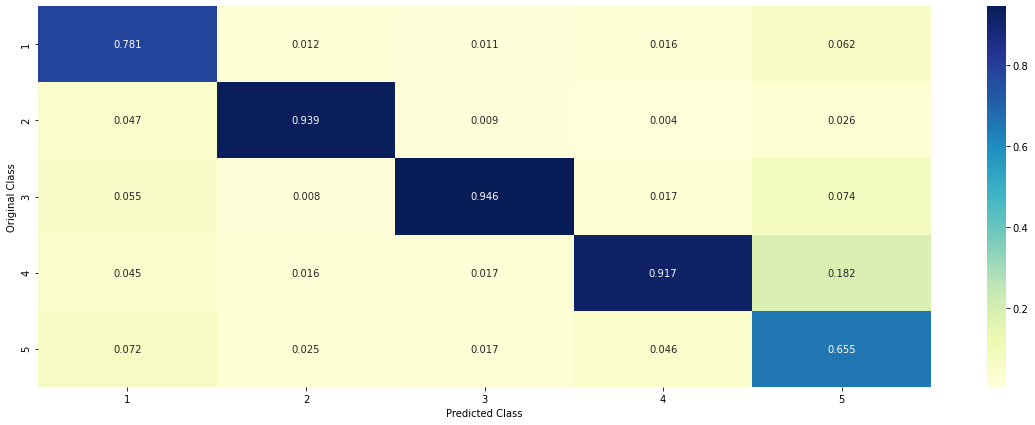

-------------------- Recall matrix (Row sum=1) --------------------


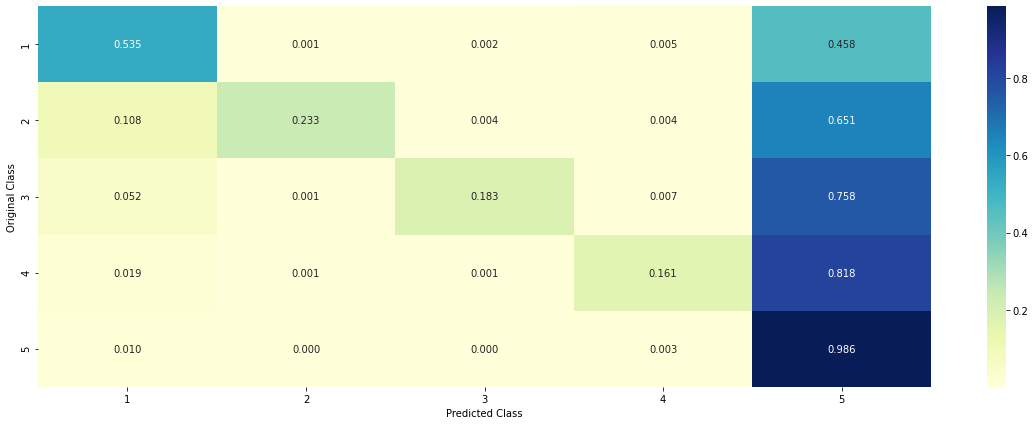

In [40]:
n_estimators=[10,20,50,100,150,200,300,500]


f1_scores = []
for i in n_estimators:
    model = None
    model = RandomForestClassifier(n_estimators=i)
    k_fold_score = kfold(5,model)
    f1_scores.append(k_fold_score)
    print("Macro F1 score at n={} is {} ".format(i,k_fold_score))

    
    
print("*"*50)    
plt.plot(n_estimators,f1_scores,color="darkblue")

plt.grid()
plt.title("Cross Validation F1 score for each n_estimators")
plt.xlabel("hyper parameter (n_estimators)")
plt.ylabel("F1 score")
plt.show()

best_param = n_estimators[np.argmax(f1_scores)]

model = None
model = RandomForestClassifier(n_estimators=best_param)
model.fit(train,y_train)


print("*"*50)
print("Train F1 score at {} is :{}".format(best_param, f1_score(y_train,model.predict(train),labels=model.classes_,average="macro")))
print("*"*50)
print("test F1 score at {} is :{}".format(best_param, f1_score(y_test,model.predict(test),labels=model.classes_,average="macro")))


#plotting confusion matrix
predicted = model.predict(test)
plot_confusion_matrix(y_test,predicted)

* Model is certainly overfitting.
* Train f1 score is 0.99, whereas test f1 score is 0.43.
* Precision for each class 1,2,3,4 increased compared to previosu models. But recall for 1,2,3,4 are very less. 
* Recall for class 5 is 98%, that is model is able to correctly predict 93% of actual class 5 points. For class 1, recall is slightly better 53.5%, Model is able to predict 53.5% of actual class 1 points correctly. 
* but for other classes recall is very low. According to business problem we need high recall for class 1,2,3. 
* Let us build other models.
    

### 1.3.6. LightGBM

In [41]:
import lightgbm as lgb

Macro F1 score at n=100 is 0.34866288904351816 
Macro F1 score at n=150 is 0.3615663865831616 
Macro F1 score at n=200 is 0.37206178512386456 
Macro F1 score at n=300 is 0.39075914150380475 
Macro F1 score at n=500 is 0.4142420051423589 
Macro F1 score at n=1000 is 0.4382468652576786 
Macro F1 score at n=2000 is 0.45450033475121226 
**************************************************


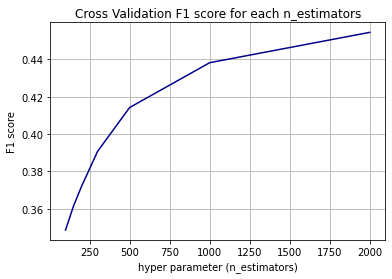

**************************************************
Train F1 score at 2000 is  :0.9917689314344624 
**************************************************
test F1 score at 2000 is :0.5124762252159244 
-------------------- Confusion matrix --------------------


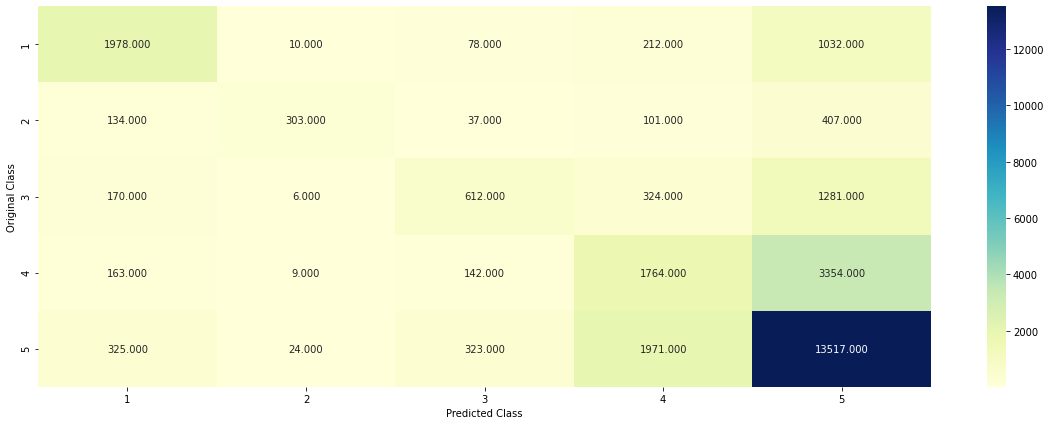

-------------------- Precision matrix (Columm Sum=1) --------------------


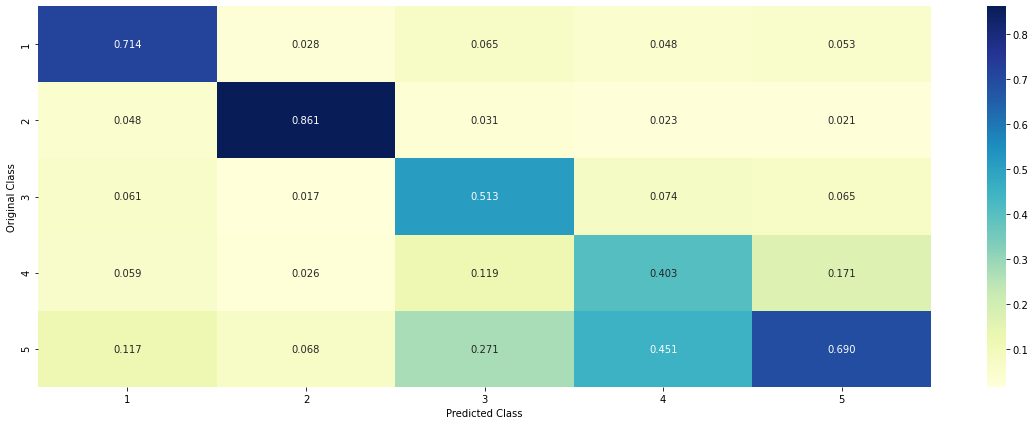

-------------------- Recall matrix (Row sum=1) --------------------


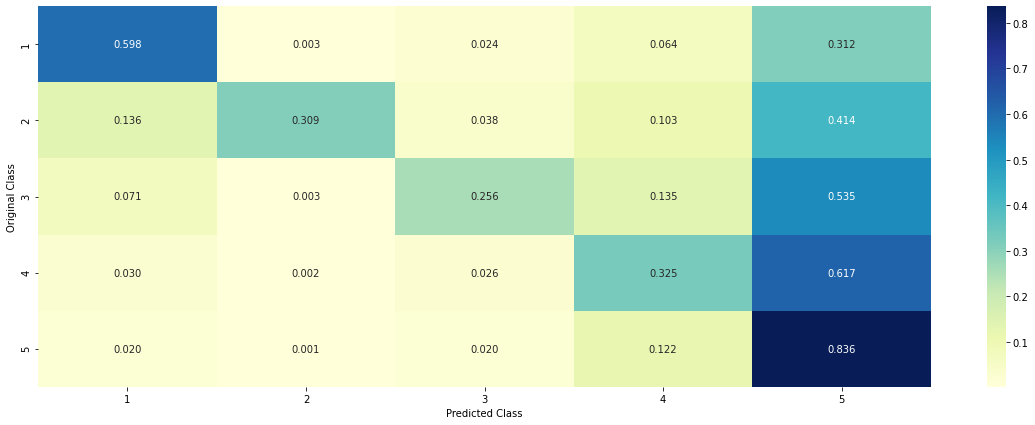

In [42]:
n_estimators=[100,150,200,300,500,1000,2000]

f1_scores = []
for i in n_estimators:
    model = None
    model = lgb.LGBMClassifier(n_estimators=i,class_weight="balanced",boosting_type ="goss")
    k_fold_score = kfold(5,model)
    f1_scores.append(k_fold_score)
    print("Macro F1 score at n={} is {} ".format(i,k_fold_score))

    
    
print("*"*50)    
plt.plot(n_estimators,f1_scores,color="darkblue")

plt.grid()
plt.title("Cross Validation F1 score for each n_estimators")
plt.xlabel("hyper parameter (n_estimators)")
plt.ylabel("F1 score")
plt.show()

best_n = n_estimators[np.argmax(f1_scores)]


model = None
model = lgb.LGBMClassifier(n_estimators=best_n,class_weight='balanced')
model.fit(train,y_train)


print("*"*50)
print("Train F1 score at {} is  :{} ".format(best_n, f1_score(y_train,model.predict(train),labels=model.classes_,average="macro")))
print("*"*50)
print("test F1 score at {} is :{} ".format(best_n, f1_score(y_test,model.predict(test),labels=model.classes_,average="macro")))


#plotting confusion matrix

predicted = model.predict(test)
plot_confusion_matrix(y_test,predicted)


In [ ]:

print(model.feature_importances_)

<b> We expected better performance from LightGBM model since we have class imbalance. So we used GOSS (Gradient Based One Side Sampling) boosting type in this. As discussed in abstract, this model is better in imbalanced data. </b>

* We can see that model is slightly overfitting. test Macro F1 score is 0.51, which is better than previous models.
* Precision for each class has improved than previous models.
* Recall for class 1,2,3,4 also improved than previous models, which is good. 
* Precision for class 4,5 is low, we should imrpove this.
* But as of now, LGBM with goss boosting worked better.
* Recall for class 1 is roughly 60%, for class 2 is 31%, for class 3 25.6%.
* Precision for class 5 is 69%, and for class 4 is 40%.

<b> <font color="red"> We can see that all models are suffering from overfitting problem.It may due to high dimensionality and useless features. Now let us do feature selection

In [44]:
#https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/

from sklearn.feature_selection import SelectKBest,f_classif

features = SelectKBest(f_classif,k=60)
train_features = features.fit_transform(train,y_train)
test_features = features.transform(test)

Macro F1 score at n=100 is 0.34400786402464406 
Macro F1 score at n=150 is 0.35750916676583266 
Macro F1 score at n=200 is 0.36769793892850716 
Macro F1 score at n=300 is 0.3834348979719837 
Macro F1 score at n=500 is 0.4049431141536156 
Macro F1 score at n=1000 is 0.42792773804251816 
Macro F1 score at n=2000 is 0.44468733953385975 
**************************************************


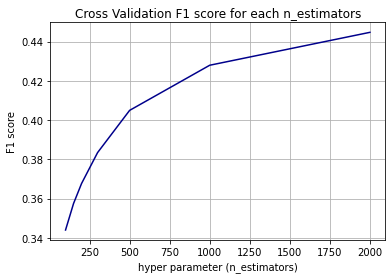

**************************************************
Train F1 score at 2000 is  :0.9900946720803109 
**************************************************
test F1 score at 2000 is :0.5139426783628179 
-------------------- Confusion matrix --------------------


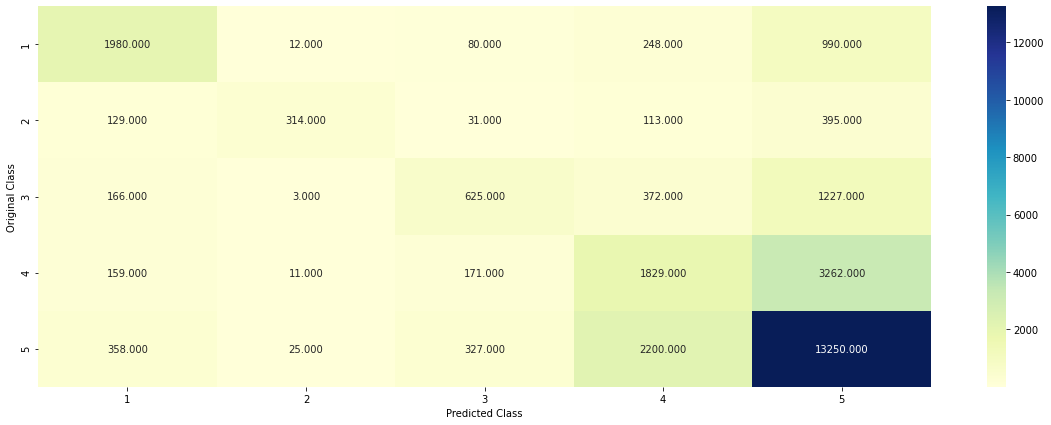

-------------------- Precision matrix (Columm Sum=1) --------------------


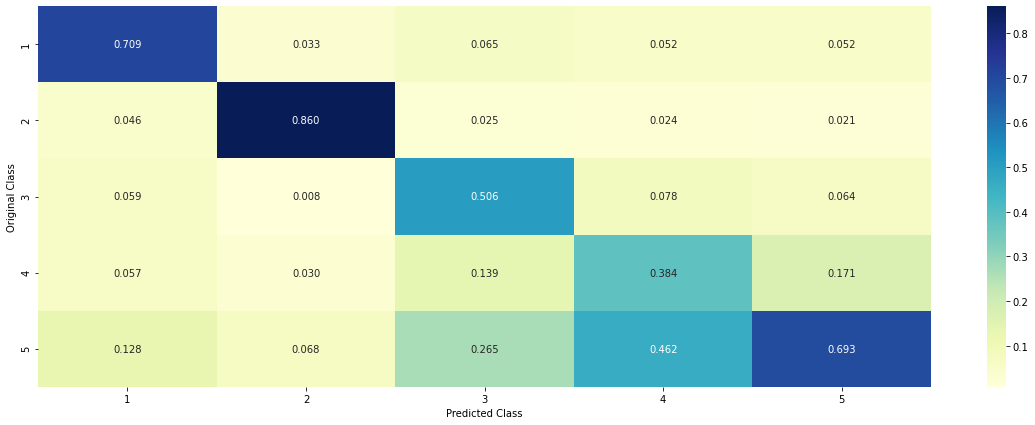

-------------------- Recall matrix (Row sum=1) --------------------


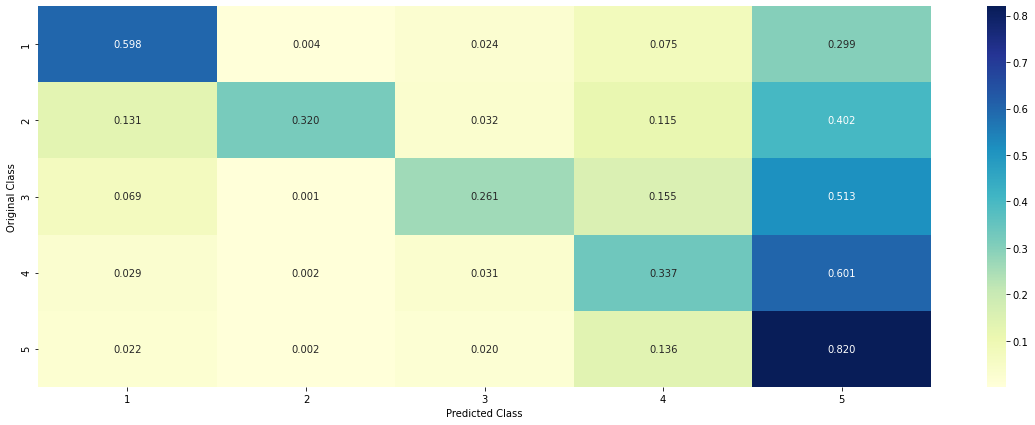

In [48]:
n_estimators=[100,150,200,300,500,1000,2000]

f1_scores = []
for i in n_estimators:
    model = None
    model = lgb.LGBMClassifier(n_estimators=i,class_weight="balanced",boosting_type ="goss")
    k_fold_score = kfold(5,model,train_features,y_train)
    f1_scores.append(k_fold_score)
    print("Macro F1 score at n={} is {} ".format(i,k_fold_score))

    
    
print("*"*50)    
plt.plot(n_estimators,f1_scores,color="darkblue")

plt.grid()
plt.title("Cross Validation F1 score for each n_estimators")
plt.xlabel("hyper parameter (n_estimators)")
plt.ylabel("F1 score")
plt.show()

best_n = n_estimators[np.argmax(f1_scores)]


model = None
model = lgb.LGBMClassifier(n_estimators=best_n,class_weight='balanced')
model.fit(train_features,y_train)


print("*"*50)
print("Train F1 score at {} is  :{} ".format(best_n, f1_score(y_train,model.predict(train_features),labels=model.classes_,average="macro")))
print("*"*50)
print("test F1 score at {} is :{} ".format(best_n, f1_score(y_test,model.predict(test_features),labels=model.classes_,average="macro")))


#plotting confusion matrix

predicted = model.predict(test_features)
plot_confusion_matrix(y_test,predicted)

* Not much improvement than previous LGBM model here by selecting top 60 features. Still there is overfitting.
* Recall for class 1 is 60%, class 2 is 32%, class 3 is 26%.
* Precision for class 5 is 69%, class 4 is 38%.

In [49]:
importance = model.feature_importances_

[  185    90   548    62    84   394   128   238    32    78    52   454
   579    91   177   116    42   237   108   565   161   246   314   156
  4928 12506  6513   936  5682   488 14531 14692 10617  9848 13818  3471
  9973 11852 10939  5419  5220  5558  5196 10040  7176  1926     0 12073
 14135 14596 15158 18222 16653 11289 13540  6791   277   168   504   128]


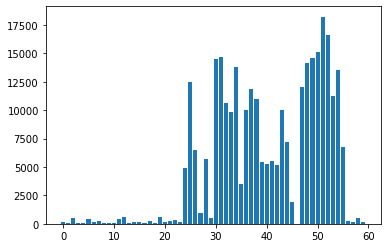

In [50]:
importance = model.feature_importances_
plt.bar([x for x in range(len(importance))], importance)
plt.show()

<b> LGBM with fine tuning

In [51]:
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1, 0.15,0.2, 0.3],
    'n_estimators': [50,100,200,250,500,1000,2000,2500]}

clf = lgb.LGBMClassifier(n_jobs=-1, class_weight="balanced", boosting_type = "goss")
random_search = RandomizedSearchCV(clf, param_grid, n_iter=30,n_jobs=-1,scoring="f1_macro", verbose=1, cv=5, refit=False, random_state=42)
random_search.fit(train, y_train)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(boosting_type='goss',
                                            class_weight='balanced'),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.1,
                                                          0.15, 0.2, 0.3],
                                        'n_estimators': [50, 100, 200, 250, 500,
                                                         1000, 2000, 2500]},
                   random_state=42, refit=False, scoring='f1_macro', verbose=1)

In [52]:
params = random_search.best_params_

In [53]:
params

{'n_estimators': 2500, 'learning_rate': 0.15}

Train F1 score is  :0.9966341300295701 
**************************************************
test F1 score is :0.4780220378617317 
-------------------- Confusion matrix --------------------


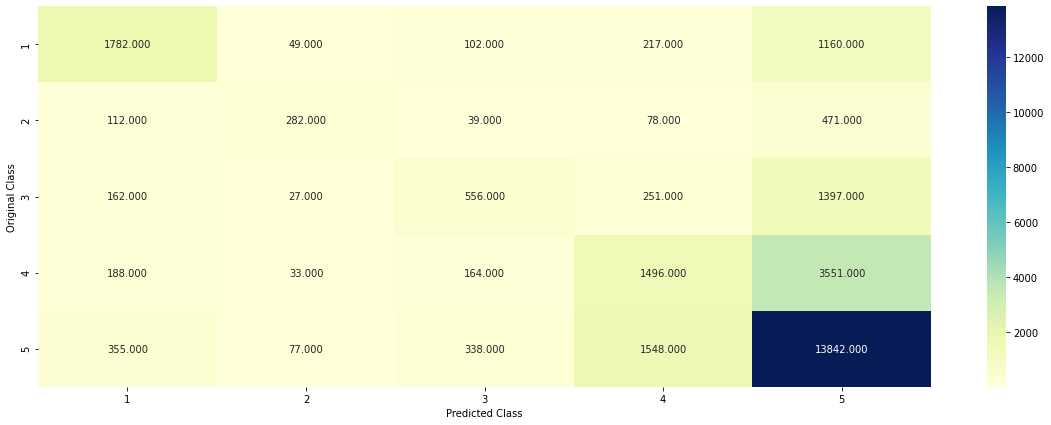

-------------------- Precision matrix (Columm Sum=1) --------------------


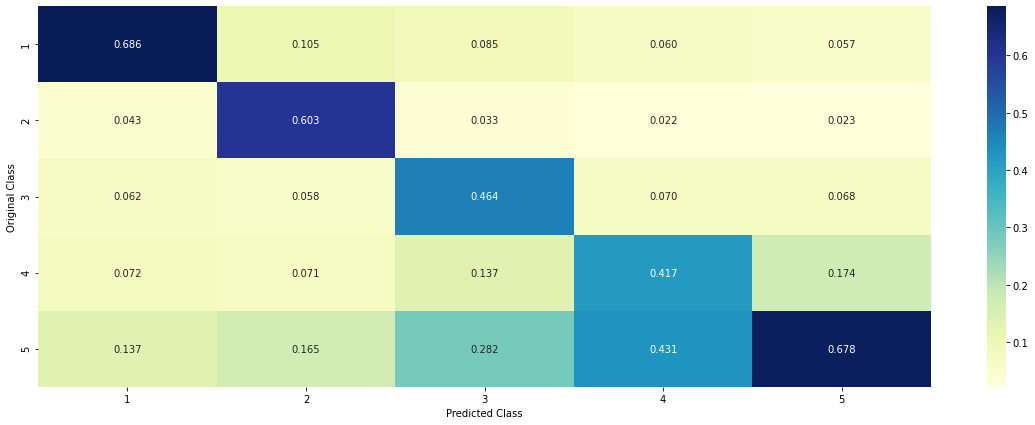

-------------------- Recall matrix (Row sum=1) --------------------


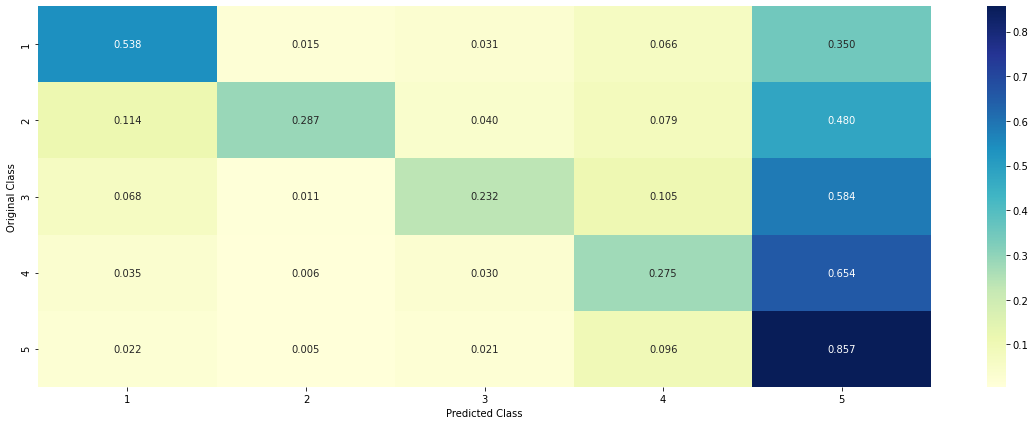

In [54]:
clf = lgb.LGBMClassifier(n_estimators= params["n_estimators"],
                        learning_rate= params["learning_rate"], n_jobs=-1,boosting_type = "goss")
clf.fit(train,y_train)

pred_test = clf.predict(test)
pred_train = clf.predict(train)

print("Train F1 score is  :{} ".format(f1_score(y_train,pred_train,labels=[1,2,3,4,5],average="macro")))
print("*"*50)
print("test F1 score is :{} ".format(f1_score(y_test,pred_test,labels=[1,2,3,4,5],average="macro")))

plot_confusion_matrix(y_test,pred_test)

* <font color="red"> No improvemnt got after fine tuning.

In [55]:
param_grid = {
    'learning_rate': [0.11,0.13,0.15,0.17,0.19],
    'n_estimators': [2000,2500]}

clf = lgb.LGBMClassifier(n_jobs=-1, class_weight="balanced", boosting_type = "goss")
random_search = RandomizedSearchCV(clf, param_grid, n_iter=30,n_jobs=-1,scoring="f1_macro", verbose=1, cv=5, refit=False, random_state=42)
random_search.fit(train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(boosting_type='goss',
                                            class_weight='balanced'),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'learning_rate': [0.11, 0.13, 0.15,
                                                          0.17, 0.19],
                                        'n_estimators': [2000, 2500]},
                   random_state=42, refit=False, scoring='f1_macro', verbose=1)

In [56]:
params = random_search.best_params_
print(params)

{'n_estimators': 2500, 'learning_rate': 0.11}


Train F1 score is  :0.9948076389453145 
**************************************************
test F1 score is :0.48265996903374164 
-------------------- Confusion matrix --------------------


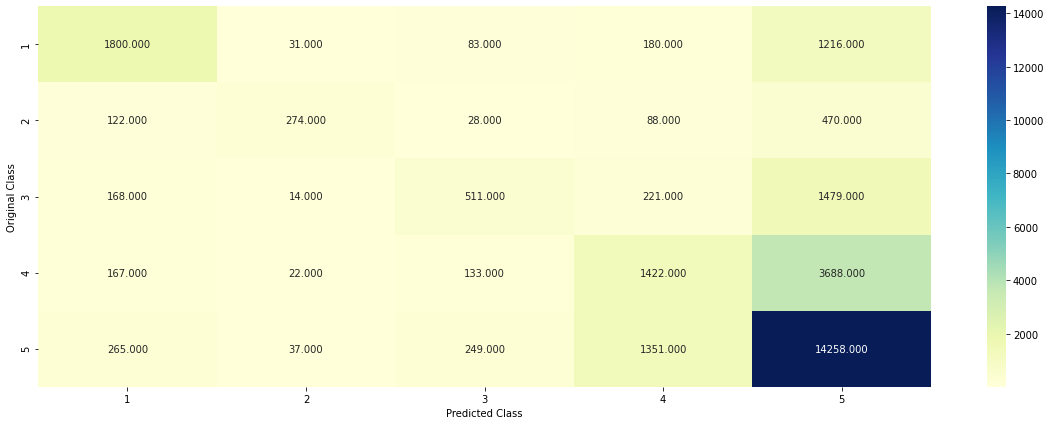

-------------------- Precision matrix (Columm Sum=1) --------------------


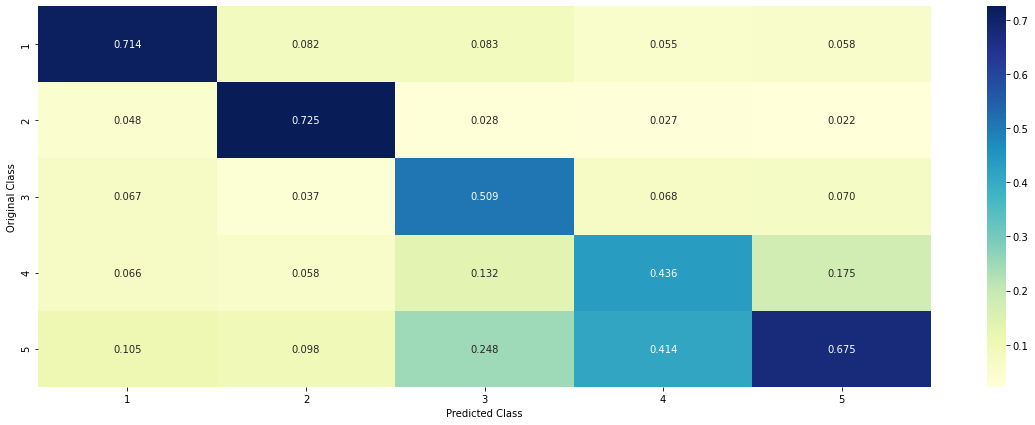

-------------------- Recall matrix (Row sum=1) --------------------


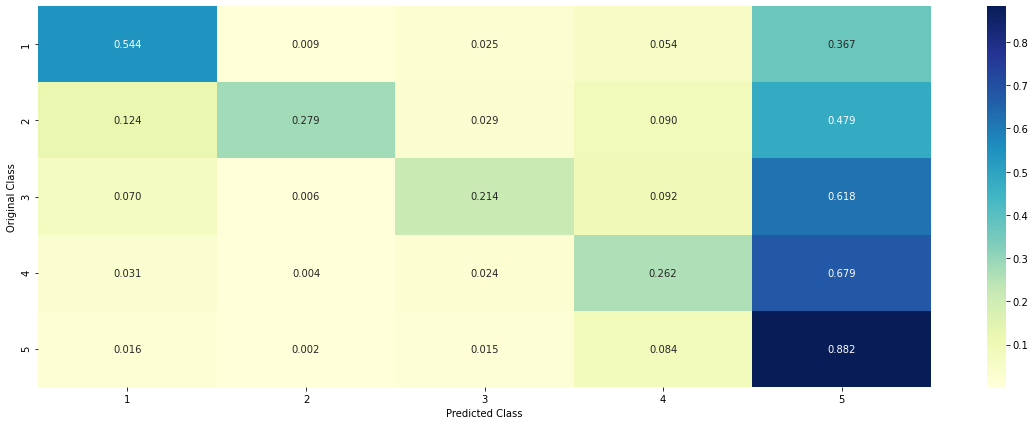

In [57]:
clf = lgb.LGBMClassifier(n_estimators= params["n_estimators"],
                        learning_rate= params["learning_rate"], n_jobs=-1,boosting_type = "goss")
clf.fit(train,y_train)

pred_test = clf.predict(test)
pred_train = clf.predict(train)

print("Train F1 score is  :{} ".format(f1_score(y_train,pred_train,labels=[1,2,3,4,5],average="macro")))
print("*"*50)
print("test F1 score is :{} ".format(f1_score(y_test,pred_test,labels=[1,2,3,4,5],average="macro")))

plot_confusion_matrix(y_test,pred_test)

* No improvement by fine tuning.

### 1.3.7. XGBoost

[08:42:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:43:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:44:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:44:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[09:01:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:02:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:03:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:03:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

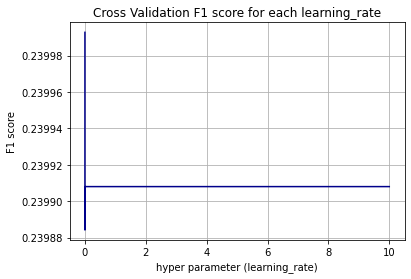

[09:07:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:08:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
**************************************************
Train F1 score at 1e-05 is  :0.24882217413212637 
**************************************************
test F1 score at 1e-05 is :0.23953227226579532 
-------------------- Confusion matrix --------------------


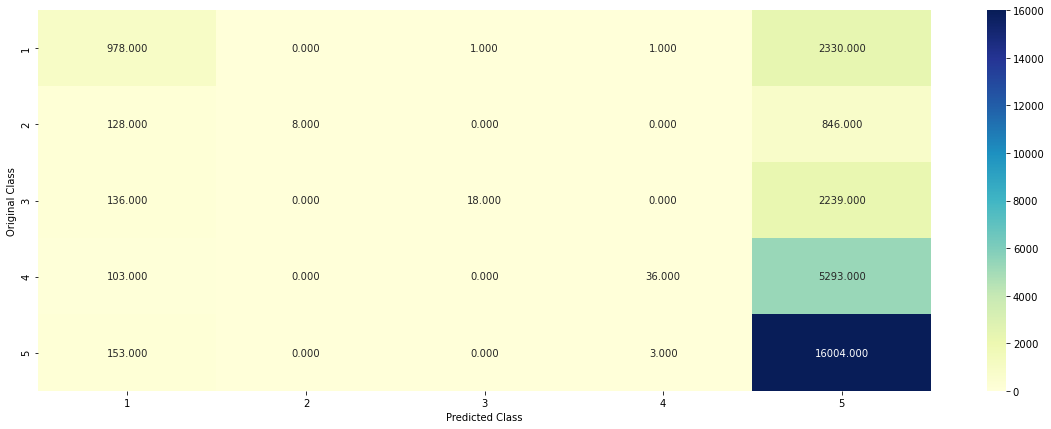

-------------------- Precision matrix (Columm Sum=1) --------------------


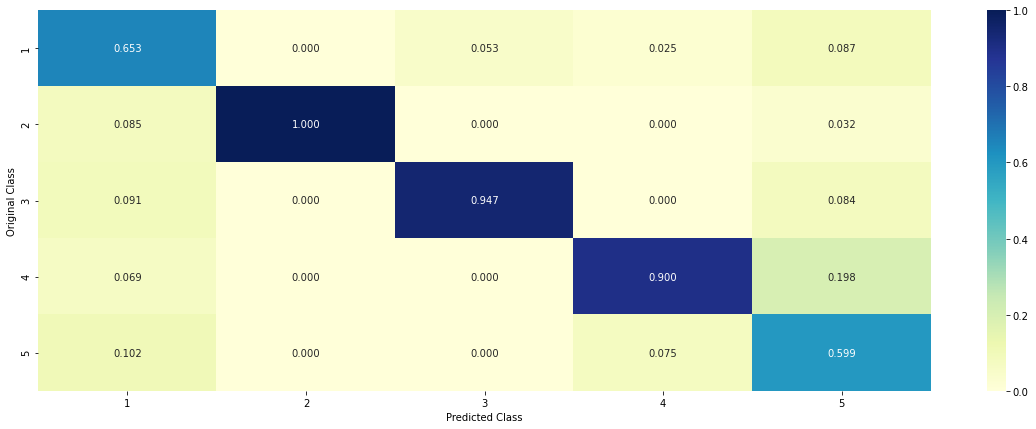

-------------------- Recall matrix (Row sum=1) --------------------


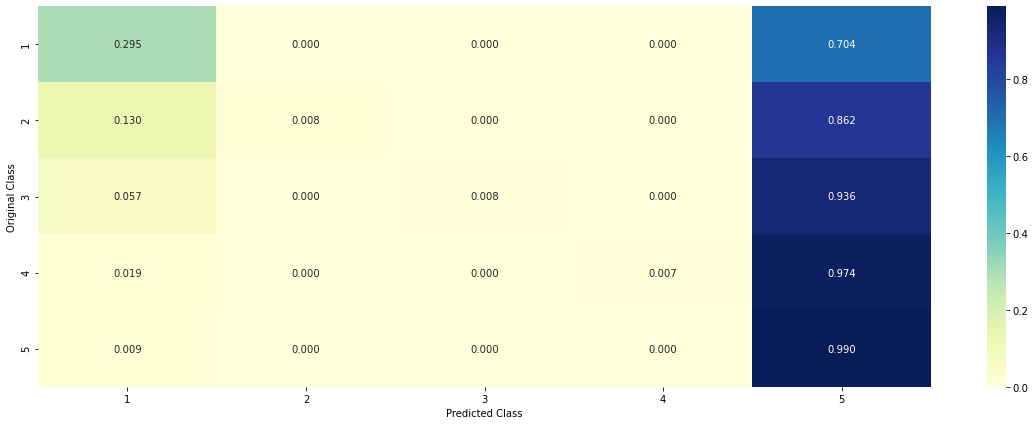

In [35]:
learning_rate=[0.00001,0.0001,0.001,0.01,0.1,1,10]

f1_scores = []
for i in learning_rate:
    model = None
    model = xgb.XGBClassifier(learning_rate=i)
    k_fold_score = kfold(5,model)
    f1_scores.append(k_fold_score)
    print("Macro F1 score at learning_rate={} is {} ".format(i,k_fold_score))

    
    
print("*"*50)    
plt.plot(learning_rate,f1_scores,color="darkblue")

plt.grid()
plt.title("Cross Validation F1 score for each learning_rate")
plt.xlabel("hyper parameter (learning_rate)")
plt.ylabel("F1 score")
plt.show()

best_n = learning_rate[np.argmax(f1_scores)]


model = None
model = xgb.XGBClassifier(learning_rate=best_n,class_weight='balanced')
model.fit(train,y_train)


print("*"*50)
print("Train F1 score at {} is  :{} ".format(best_n, f1_score(y_train,model.predict(train),labels=model.classes_,average="macro")))
print("*"*50)
print("test F1 score at {} is :{} ".format(best_n, f1_score(y_test,model.predict(test),labels=model.classes_,average="macro")))


#plotting confusion matrix

predicted = model.predict(test)
plot_confusion_matrix(y_test,predicted)

* XGBRFClassifier is not working good. Recall for class 2,3,4 are very less. but precision is high for this class. 
* And recall for class 5 is high, But precision is just 59%.
* It seems that it is not giving importance to class 2,3,4.

<b> XGBoost with fine hyperparameter tuning

In [36]:
param_grid = {
    'max_depth': [2,3,4,5,6,7,8],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'n_estimators': [5,10,50,100,200,250]}

clf = xgb.XGBClassifier(n_jobs=-1 ,early_stopping_rounds = 10, eta = 0.02 )
random_search = RandomizedSearchCV(clf, param_grid, n_iter=30,n_jobs=-1,scoring="f1_macro", verbose=1, cv=5, refit=False, random_state=42)
random_search.fit(train, y_train)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=10, eta=0.02,
                                           gamma=None, gpu_id=None,
                                           importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_...
                                           num_parallel_tree=None,
                                           random_state=None, reg_alph

In [37]:
params = random_search.best_params_

In [38]:
params

{'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.2}

[10:31:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:31:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train F1 score is  :0.5387918992086534 
**************************************************
test F1 score is :0.35880636075112976 
-------------------- Confusion matrix --------------------


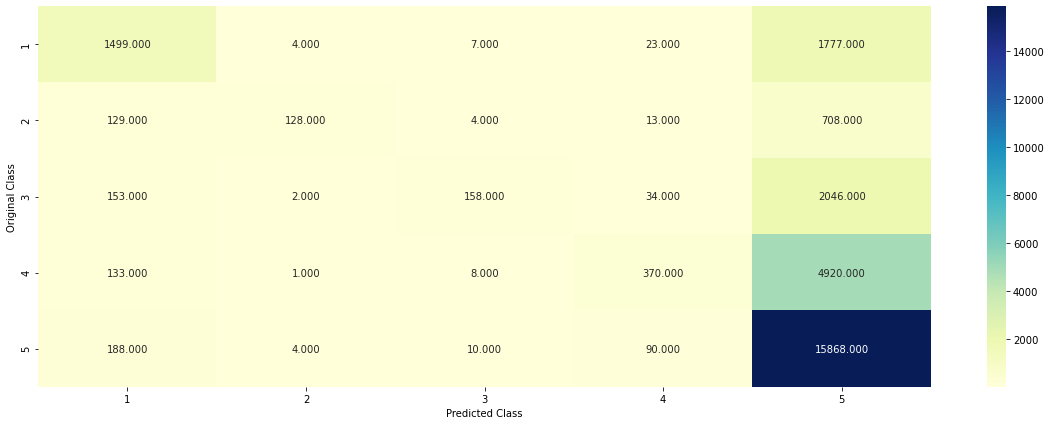

-------------------- Precision matrix (Columm Sum=1) --------------------


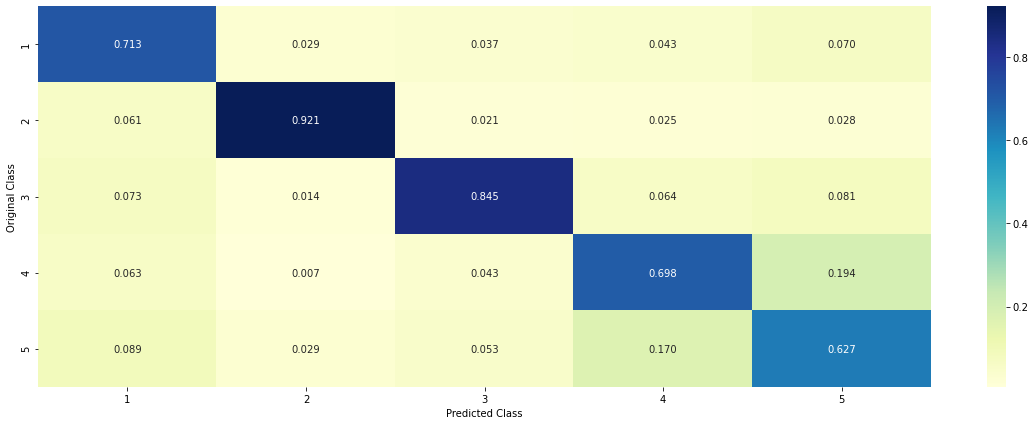

-------------------- Recall matrix (Row sum=1) --------------------


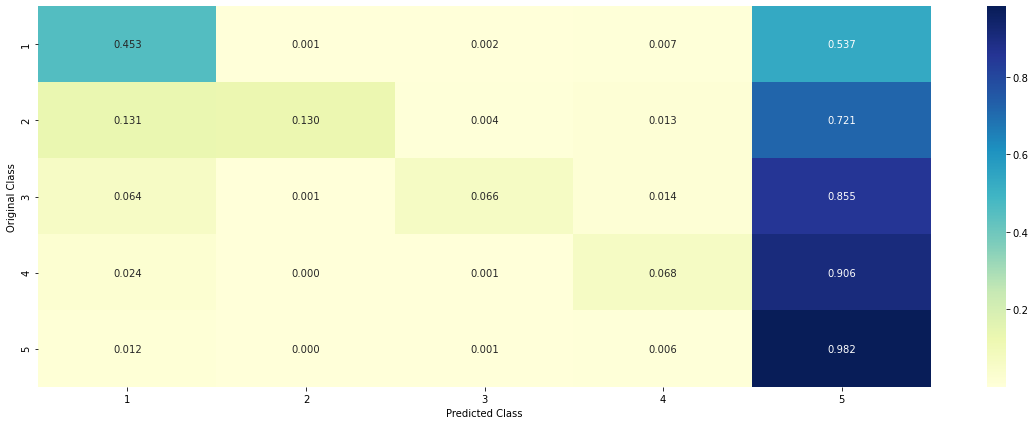

In [39]:
clf = xgb.XGBClassifier(n_estimators= params["n_estimators"], max_depth= params["max_depth"],
                        learning_rate= params["learning_rate"]  ,early_stopping_rounds = 10, eta = 0.02 )

clf.fit(train,y_train)

pred_test = clf.predict(test)
pred_train = clf.predict(train)

print("Train F1 score is  :{} ".format(f1_score(y_train,pred_train,labels=[1,2,3,4,5],average="macro")))
print("*"*50)
print("test F1 score is :{} ".format(f1_score(y_test,pred_test,labels=[1,2,3,4,5],average="macro")))

plot_confusion_matrix(y_test,pred_test)

* This works slightly better for class 5 and class 1. But class 2,3,4 are suffuring from misclassification as before. Recall for class 2,3,4 are very less. 
* Macro f1 score is also not much good.

<b> Macro F1 score is not improving much. Also there is misclassification, this may due to class imbalance. So we need class balancing techniques.

Let us try Random Over Sampling technique to handle class imbalance.

### 1.4 Random Over Sampling

In [58]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [59]:
om = RandomOverSampler(random_state=10) 
x_res , y_res = om.fit_resample(train_features,y_train)

In [60]:
x_res.shape

(242385, 60)

In [61]:
print("class distribution BEFORE SMOTE in train data: \n",y_train.value_counts())
print("class distribution AFTER SMOTE in train data: \n",y_res.value_counts())

class distribution BEFORE SMOTE in train data: 
 5    48477
4    16293
1     9931
3     7180
2     2947
Name: review_score, dtype: int64
class distribution AFTER SMOTE in train data: 
 4    48477
3    48477
5    48477
2    48477
1    48477
Name: review_score, dtype: int64


In [66]:
def kfold_sampling(k,model):
    """This function will do stratified k-fold cross_validation"""
    kf = StratifiedKFold(n_splits=k)
    
    cv_f1_score = []
    for tr_ind,cv_ind in kf.split(x_res,y_res):
            
        x_tr,x_cv,y_tr,y_cv = x_res[tr_ind],x_res[cv_ind],y_res[tr_ind],y_res[cv_ind]
        
        model.fit(x_tr,y_tr)
        pred_cv = model.predict(x_cv)    
        cv_f1_score.append((f1_score(y_cv,pred_cv,average="macro",labels=[1,2,3,4,5])))
    
    return np.mean(cv_f1_score)   
            

### 1.4.1 Logistic Regression:

Macro F1 score at C=1e-05 is 0.2620845225477523 
Macro F1 score at C=0.0001 is 0.2833944832922826 
Macro F1 score at C=0.001 is 0.2919762997087313 
Macro F1 score at C=0.01 is 0.29396414803265347 
Macro F1 score at C=0.1 is 0.29453436831243 
Macro F1 score at C=1 is 0.29510303180450576 
Macro F1 score at C=10 is 0.29481818351258066 
**************************************************


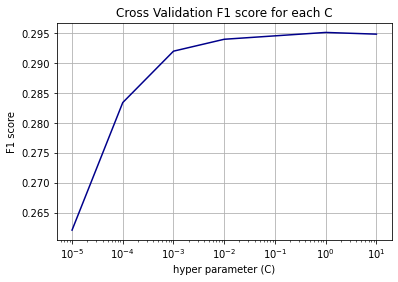

**************************************************
Train F1 score at 1 is :0.29554956053539866
**************************************************
test F1 score at 1 is :0.28287059666769154
-------------------- Confusion matrix --------------------


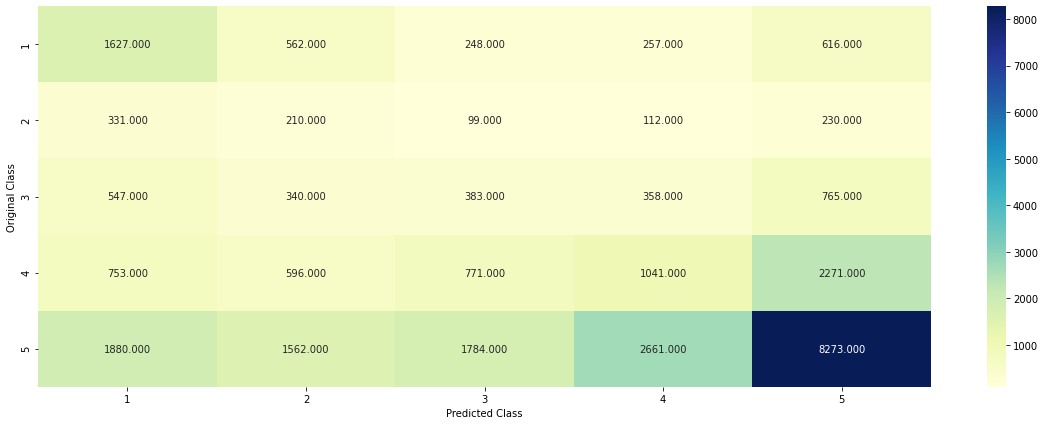

-------------------- Precision matrix (Columm Sum=1) --------------------


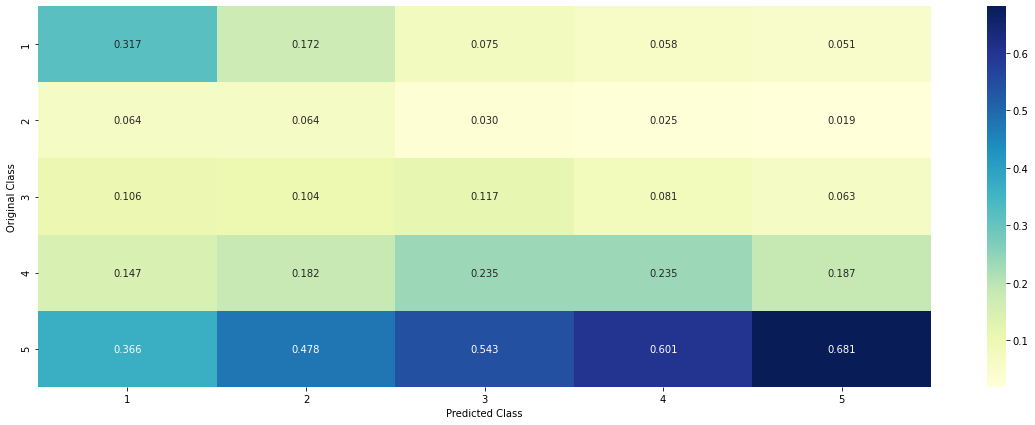

-------------------- Recall matrix (Row sum=1) --------------------


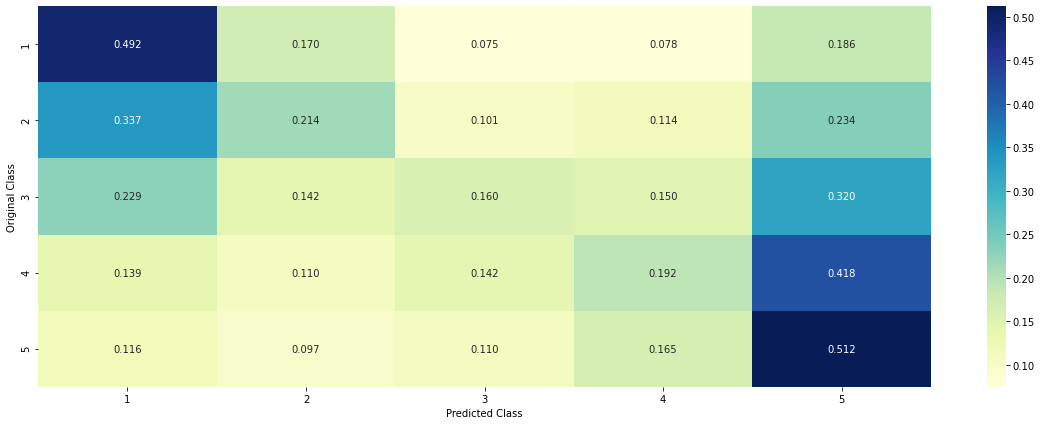

In [64]:
C=[0.00001,0.0001,0.001,0.01,0.1,1,10]

f1_scores = []
for i in C:
    model = None
    model = LogisticRegression(C=i)
    k_fold_score = kfold_sampling(5,model)
    f1_scores.append(k_fold_score)
    print("Macro F1 score at C={} is {} ".format(i,k_fold_score))

    
    
print("*"*50)    
plt.plot(C,f1_scores,color="darkblue")
plt.xscale("log")
plt.grid()
plt.title("Cross Validation F1 score for each C")
plt.xlabel("hyper parameter (C)")
plt.ylabel("F1 score")
plt.show()

best_param = C[np.argmax(f1_scores)]

model = None
model = LogisticRegression(C=i)
model.fit(x_res,y_res)


print("*"*50)
print("Train F1 score at {} is :{}".format(best_param, f1_score(y_res,model.predict(x_res),labels=model.classes_,average="macro")))
print("*"*50)
print("test F1 score at {} is :{}".format(best_param, f1_score(y_test,model.predict(test_features),labels=model.classes_,average="macro")))


#plotting confusion matrix
predicted = model.predict(test_features)
plot_confusion_matrix(y_test,predicted)

### 1.4.2. Decision Tree

Macro F1 score at n=2 is 0.17082335139712285 
Macro F1 score at n=5 is 0.2713285349133917 
Macro F1 score at n=6 is 0.2863762832795523 
Macro F1 score at n=8 is 0.3197392847300593 
Macro F1 score at n=10 is 0.3641308575548703 
Macro F1 score at n=12 is 0.40877818290076495 
Macro F1 score at n=15 is 0.49739722106370027 
Macro F1 score at n=20 is 0.6526854356549808 
**************************************************


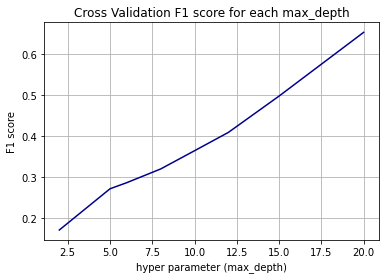

**************************************************
Train F1 score at 20 is :0.7016532041986847
**************************************************
test F1 score at 20 is :0.34301458062753587
-------------------- Confusion matrix --------------------


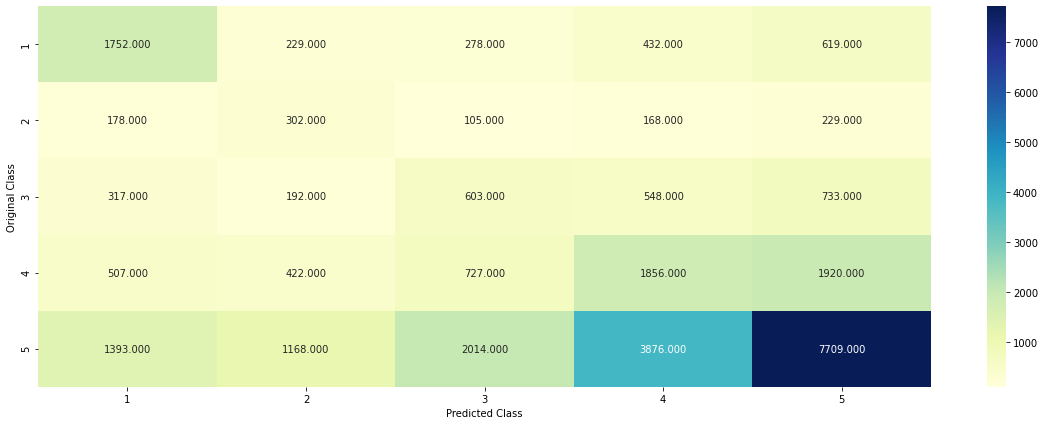

-------------------- Precision matrix (Columm Sum=1) --------------------


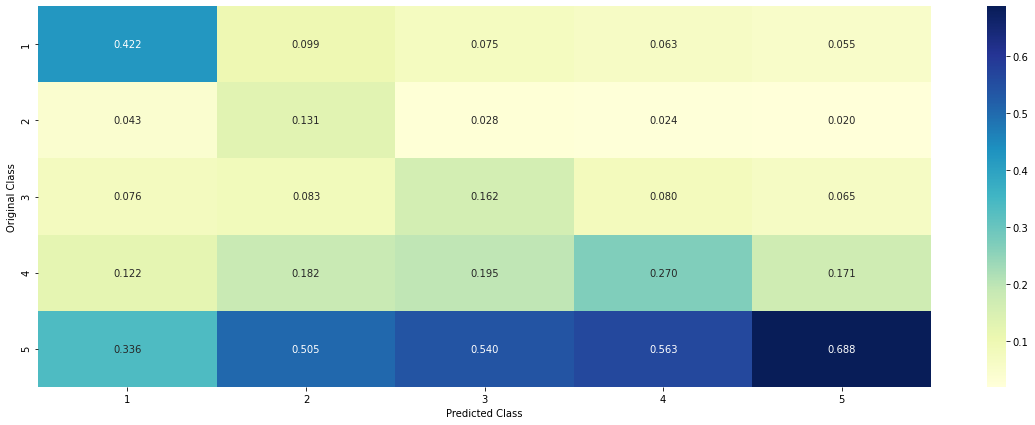

-------------------- Recall matrix (Row sum=1) --------------------


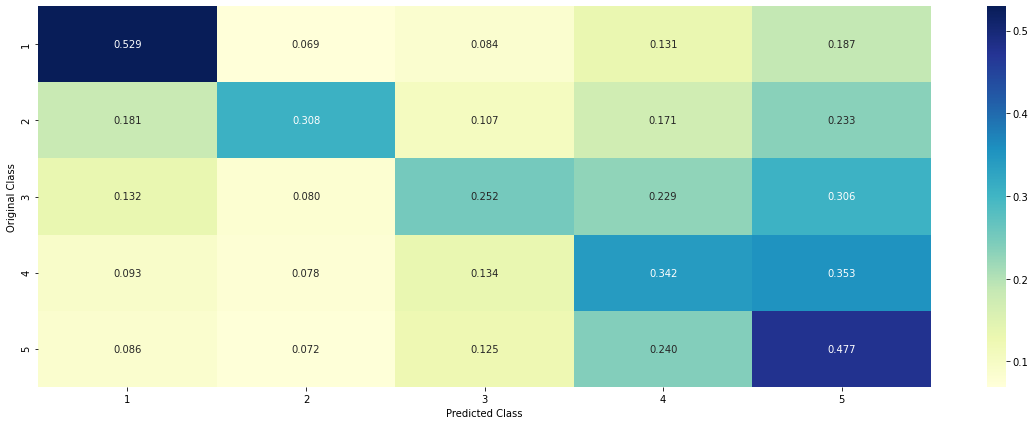

In [69]:
max_depth=[2,5,6,8,10,12,15,20]

f1_scores = []
for i in max_depth:
    model = None
    model = DecisionTreeClassifier(max_depth=i)
    k_fold_score = kfold_sampling(5,model)
    f1_scores.append(k_fold_score)
    print("Macro F1 score at n={} is {} ".format(i,k_fold_score))

    
    
print("*"*50)    
plt.plot(max_depth,f1_scores,color="darkblue")

plt.grid()
plt.title("Cross Validation F1 score for each max_depth")
plt.xlabel("hyper parameter (max_depth)")
plt.ylabel("F1 score")
plt.show()

best_param = max_depth[np.argmax(f1_scores)]

model = None
model = DecisionTreeClassifier(max_depth=best_param)
model.fit(x_res,y_res)


print("*"*50)
print("Train F1 score at {} is :{}".format(best_param, f1_score(y_res,model.predict(x_res),labels=model.classes_,average="macro")))
print("*"*50)
print("test F1 score at {} is :{}".format(best_param, f1_score(y_test,model.predict(test_features),labels=model.classes_,average="macro")))


#plotting confusion matrix
predicted = model.predict(test_features)
plot_confusion_matrix(y_test,predicted)

* And no much good performance on any class label.
* High misclassification.

* RandomForest is bagging method, that means it has overfitted Decision trees as base learners. But ensembling overfitting will reduce. 
* Since decision tree is overfitting in this situation, let us try with RandomForest with random Oversampling

### RF

Macro F1 score at n=10 is 0.9313607423429751 
Macro F1 score at n=20 is 0.9535549871158185 
Macro F1 score at n=50 is 0.9697554781509881 
Macro F1 score at n=100 is 0.975800176793355 
Macro F1 score at n=150 is 0.9778040758575797 
Macro F1 score at n=200 is 0.9784423486493914 
Macro F1 score at n=300 is 0.9794255424476516 
Macro F1 score at n=500 is 0.9801736967596921 
**************************************************


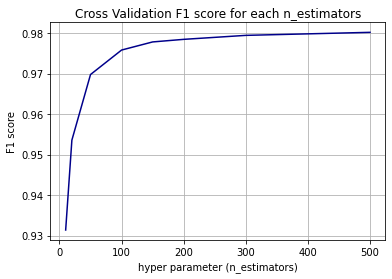

**************************************************
Train F1 score at 500 is :0.9985973924070967
**************************************************
test F1 score at 500 is :0.5136173216792821
-------------------- Confusion matrix --------------------


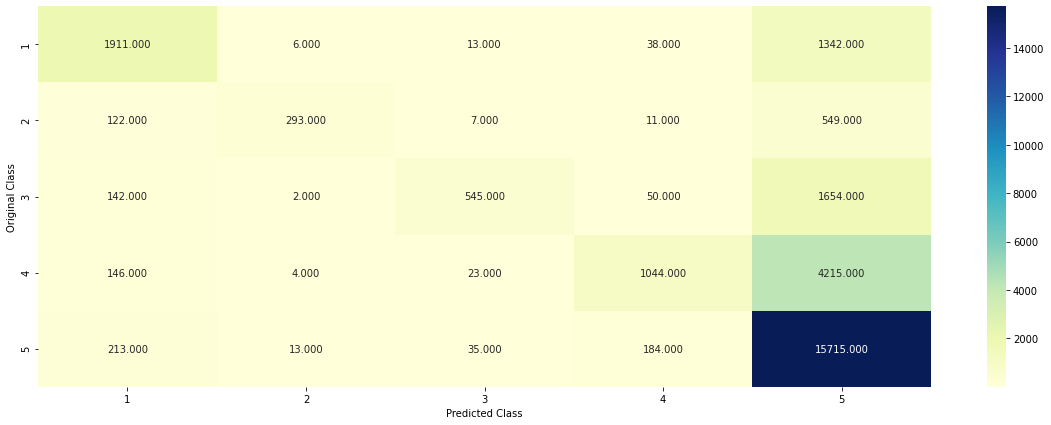

-------------------- Precision matrix (Columm Sum=1) --------------------


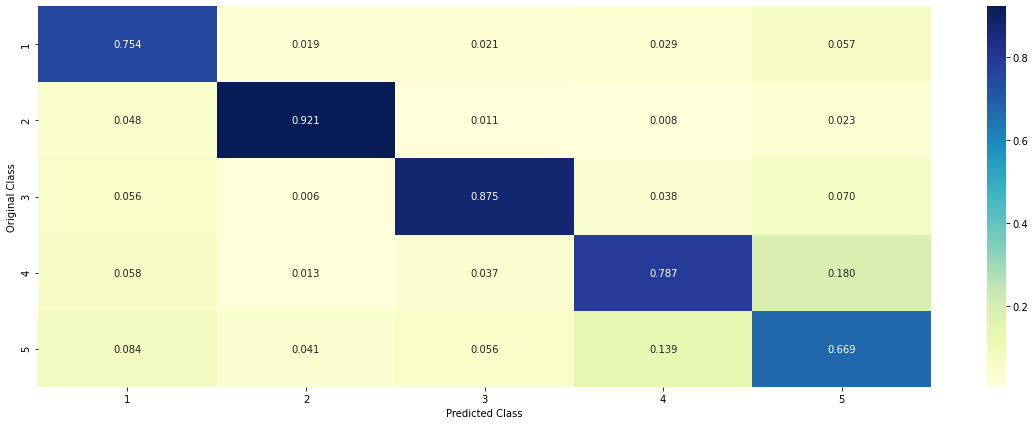

-------------------- Recall matrix (Row sum=1) --------------------


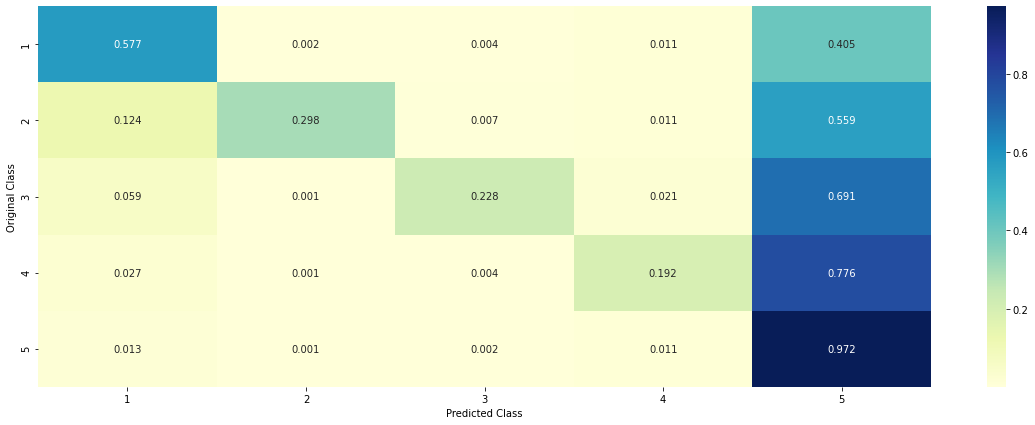

In [75]:
n_estimators=[10,20,50,100,150,200,300,500]


f1_scores = []
for i in n_estimators:
    model = None
    model = RandomForestClassifier(n_estimators=i)
    k_fold_score = kfold_sampling(5,model)
    f1_scores.append(k_fold_score)
    print("Macro F1 score at n={} is {} ".format(i,k_fold_score))

    
    
print("*"*50)    
plt.plot(n_estimators,f1_scores,color="darkblue")

plt.grid()
plt.title("Cross Validation F1 score for each n_estimators")
plt.xlabel("hyper parameter (n_estimators)")
plt.ylabel("F1 score")
plt.show()

best_param = n_estimators[np.argmax(f1_scores)]

model = None
model = RandomForestClassifier(n_estimators=best_param)
model.fit(x_res,y_res)


print("*"*50)
print("Train F1 score at {} is :{}".format(best_param, f1_score(y_res,model.predict(x_res),labels=model.classes_,average="macro")))
print("*"*50)
print("test F1 score at {} is :{}".format(best_param, f1_score(y_test,model.predict(test_features),labels=model.classes_,average="macro")))


#plotting confusion matrix
predicted = model.predict(test_features)
plot_confusion_matrix(y_test,predicted)

* But the model is overfitting

### XGBRF model

[21:11:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:12:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:14:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:15:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[21:46:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:49:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:51:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:54:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

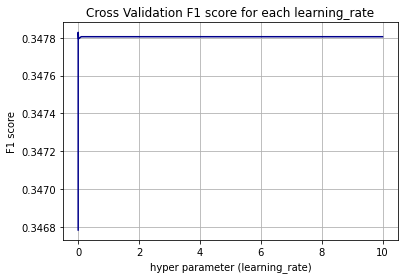

[22:05:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:07:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
**************************************************
Train F1 score at 0.001 is  :0.35404401698400156 
**************************************************
test F1 score at 0.001 is :0.30375644020951065 
-------------------- Confusion matrix --------------------


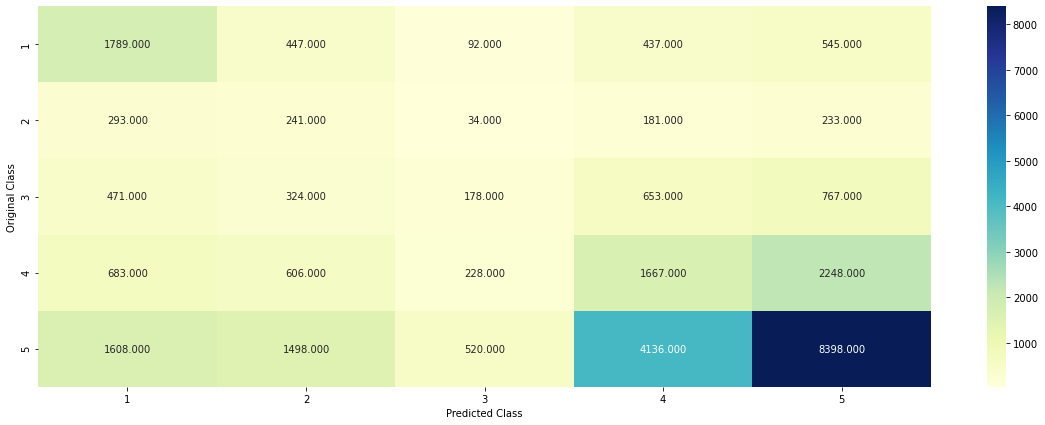

-------------------- Precision matrix (Columm Sum=1) --------------------


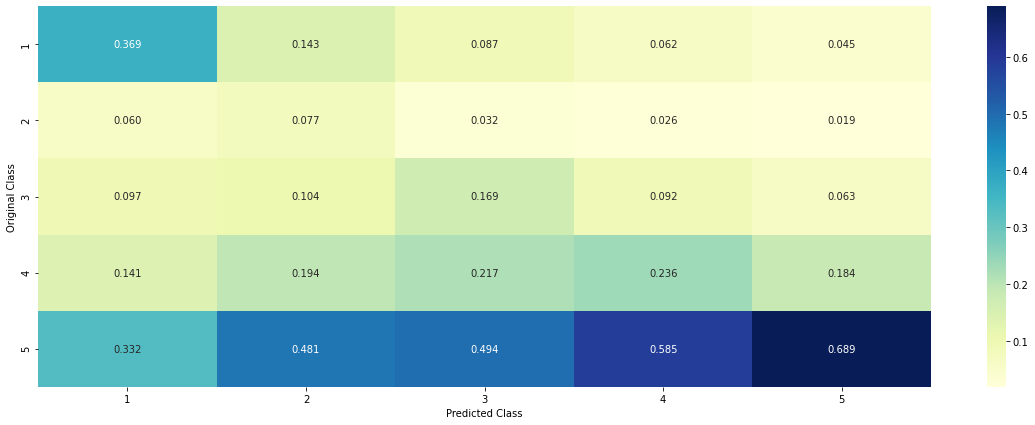

-------------------- Recall matrix (Row sum=1) --------------------


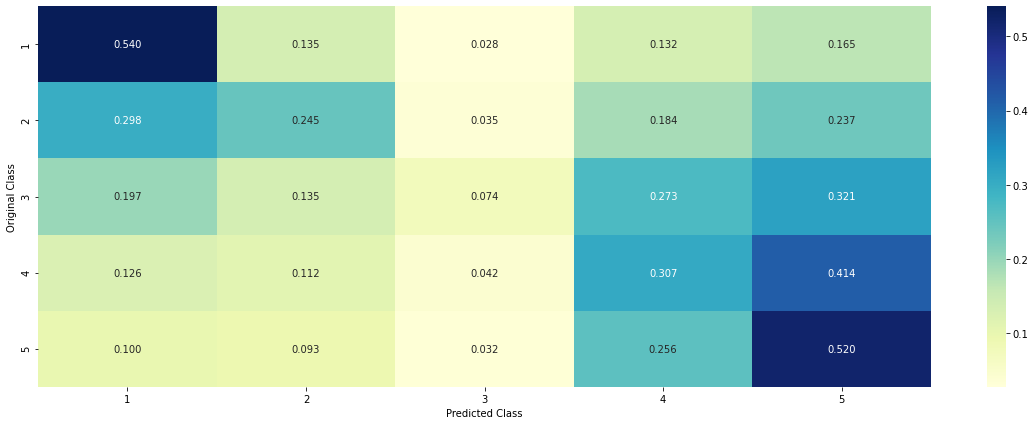

In [76]:
learning_rate=[0.00001,0.0001,0.001,0.01,0.1,1,10]

f1_scores = []
for i in learning_rate:
    model = None
    model = xgb.XGBRFClassifier(learning_rate=i)
    k_fold_score = kfold_sampling(5,model)
    f1_scores.append(k_fold_score)
    print("Macro F1 score at learning_rate={} is {} ".format(i,k_fold_score))

    
    
print("*"*50)    
plt.plot(learning_rate,f1_scores,color="darkblue")

plt.grid()
plt.title("Cross Validation F1 score for each learning_rate")
plt.xlabel("hyper parameter (learning_rate)")
plt.ylabel("F1 score")
plt.show()

best_n = learning_rate[np.argmax(f1_scores)]


model = None
model = xgb.XGBRFClassifier(learning_rate=best_n,class_weight='balanced')
model.fit(x_res,y_res)


print("*"*50)
print("Train F1 score at {} is  :{} ".format(best_n, f1_score(y_res,model.predict(x_res),labels=model.classes_,average="macro")))
print("*"*50)
print("test F1 score at {} is :{} ".format(best_n, f1_score(y_test,model.predict(test_features),labels=model.classes_,average="macro")))


#plotting confusion matrix

predicted = model.predict(test_features)
plot_confusion_matrix(y_test,predicted)

### 1.4.3. LGBM

In [71]:
param_grid = { 
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'n_estimators': [5,10,50,100,200,250]}

clf = lgb.LGBMClassifier(n_jobs=-1,boosting_type="goss")
random_search = RandomizedSearchCV(clf, param_grid, n_iter=30,n_jobs=-1,scoring="f1_macro",
                                   verbose=1, cv=5, refit=False, random_state=42)
random_search.fit(x_res, y_res)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


RandomizedSearchCV(cv=5, estimator=LGBMClassifier(boosting_type='goss'),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.1,
                                                          0.2],
                                        'n_estimators': [5, 10, 50, 100, 200,
                                                         250]},
                   random_state=42, refit=False, scoring='f1_macro', verbose=1)

In [72]:
params = random_search.best_params_

In [73]:
print(params)

{'n_estimators': 250, 'learning_rate': 0.1}


Train F1 score is  :0.7637536506482032 
**************************************************
test F1 score is :0.39361553077802675 
-------------------- Confusion matrix --------------------


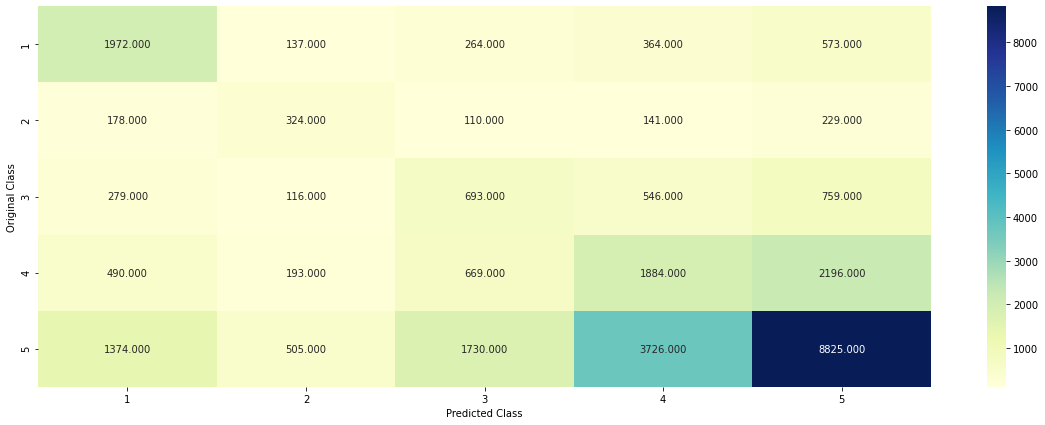

-------------------- Precision matrix (Columm Sum=1) --------------------


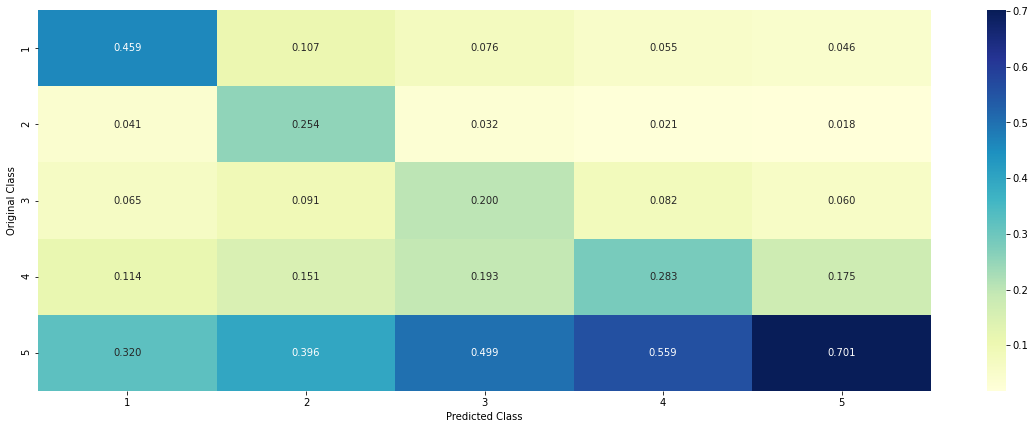

-------------------- Recall matrix (Row sum=1) --------------------


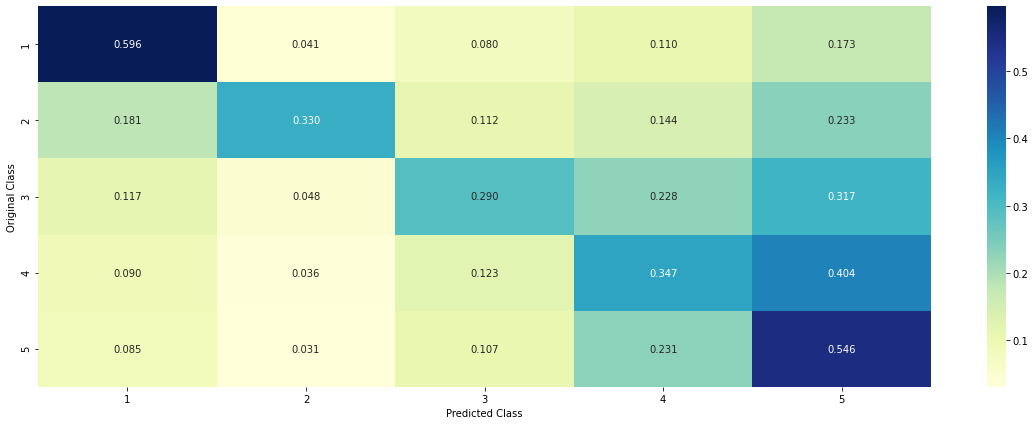

In [74]:
clf = lgb.LGBMClassifier(n_estimators= params["n_estimators"],
                         boosting_type="goss",
                        learning_rate= params["learning_rate"], n_jobs=-1)
clf.fit(x_res,y_res)

pred_test = clf.predict(test_features)
pred_train = clf.predict(x_res)

print("Train F1 score is  :{} ".format(f1_score(y_res,pred_train,labels=[1,2,3,4,5],average="macro")))
print("*"*50)
print("test F1 score is :{} ".format(f1_score(y_test,pred_test,labels=[1,2,3,4,5],average="macro")))

plot_confusion_matrix(y_test,pred_test)

* <b> Test macro F1 score is not imrpoved. But main observation here is the model gave some importance to minority classes. And recall of class 1 is 60%, class 2 is 33%, class 3 is 29%. This is littile bit improvemtn. 
* Also Precision of class 5 is 70%.

* With oversampling, result has not improved incase of LGBM
* Still model is suffering from misclassification error.

## Summary Table

<b> We have performed 5-fold cross validation for all models. 
    
    In some models difference between test and train macro F1 score is high, in some models this difference is low. 
    We have not get high macro F1 score for any model. 
    

<b> With original data

|Model|Test Macro_F1 score| Train Macro_F1 score|
|----|----|----|
| Logistic Regression|0.284 |0.286 |
| KNN | 0.35|0.64|
| Decision Tree|0.32 |0.44 |
| Random Forest |0.433 |0.993 |
| Light GBM with goss|0.51 |0.98 |
|Light GBM with goss+ fine tuning|0.46 |0.99 |
| XGBRFBoost|0.239 |0.249 |
|XGBoost|0.359 |0.539|


<b> With Random Oversampling

|Model|Test Macro_F1 score|Train Macro_F1 score|
|----|----|----|
|Logistic Regression|0.28 |0.30 |
|Decision Tree|0.38 |0.70 |
|Random Forest|0.51|0.99|
|XGBRF|0.30|0.35|
|Light GBM|0.39 |0.76 |



* We can see that result has not improved with RandomOverSampling.
* LightGBM with goss boosting type is the model which gave better result compared to all other models with macro F1 score 0.513.